# Classification Supervisée — Biens de Consommation (Place de Marché)

**Objectif** : développer un modèle de classification supervisée pour automatiser la catégorisation des produits à partir de leur description textuelle et de leur image.

**Plan du notebook** :
1. Configuration et imports
2. Chargement et préparation des données
3. Division stratifiée des données (train/val/test)
4. Modèles de référence (baseline) et Classification sur caractéristiques textuelles
5. Classification sur caractéristiques visuelles 
6. Deep Learning et fusion multimodale
7. Evaluation comparative finale
8. Analyse détaillée du meilleur modèle
9. Conclusion et recommandations

**Dataset** : Flipkart e-commerce sample (600 produits sélectionnés, 7 catégories)

## 1. Configuration et imports

In [1]:
# Configuration et imports
import os, sys, re, json, math, warnings, random
from pathlib import Path
import pickle
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid', context='notebook')

# Machine Learning
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier

# Métriques et évaluation
from sklearn.metrics import (
    classification_report, confusion_matrix, accuracy_score,
    precision_recall_fscore_support, roc_auc_score, roc_curve
)

# Deep Learning
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Model
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as mobilenet_preprocess
from tensorflow.keras.preprocessing import image as keras_image
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# Prétraitement texte
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

# Traitement d'images
import cv2
from PIL import Image

# Configuration
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
random.seed(RANDOM_STATE)
tf.random.set_seed(RANDOM_STATE)

# Chemins des données
PROJECT_ROOT = Path('/Users/laureendademeule/Documents/Projets/P6')
DATA_CSV_PATH = PROJECT_ROOT / 'data' / 'Flipkart' / 'flipkart_com-ecommerce_sample_1050.csv'
IMAGES_DIR = PROJECT_ROOT / 'data' / 'Flipkart' / 'Images'
ARTIFACTS_DIR = PROJECT_ROOT / 'data' / 'artifacts'
ARTIFACTS_DIR.mkdir(exist_ok=True)

print('TensorFlow version:', tf.__version__)
print('GPU available:', len(tf.config.list_physical_devices('GPU')) > 0)
print('Artifacts directory:', ARTIFACTS_DIR)


TensorFlow version: 2.16.2
GPU available: True
Artifacts directory: /Users/laureendademeule/Documents/Projets/P6/data/artifacts


## 2. Chargement et préparation des données


In [2]:
# Fonctions de prétraitement (reprises du notebook précédent)
try:
    _ = stopwords.words('english')
    _ = word_tokenize('test sentence')
    _ = WordNetLemmatizer()
except LookupError:
    nltk.download('punkt')
    nltk.download('stopwords')
    nltk.download('wordnet')

STOPWORDS = set(stopwords.words('english'))
LEMMATIZER = WordNetLemmatizer()
TOKENIZER_RE = re.compile(r"[A-Za-z]+")

def clean_text(text: str) -> str:
    """Nettoie le texte : minuscules, suppression ponctuation, stopwords, lemmatisation"""
    if not isinstance(text, str):
        return ''
    text = text.lower()
    tokens = TOKENIZER_RE.findall(text)
    tokens = [LEMMATIZER.lemmatize(t) for t in tokens if t not in STOPWORDS and len(t) > 2]
    return ' '.join(tokens)

def parse_primary_category(cat_str: str) -> str:
    """Extrait la catégorie principale depuis product_category_tree"""
    if not isinstance(cat_str, str) or len(cat_str) == 0:
        return 'Unknown'
    try:
        s = cat_str.strip()
        if s.startswith('['):
            s = s[1:-1]
        s = s.strip().strip('"')
        parts = [p.strip() for p in s.split('>>') if len(p.strip()) > 0]
        return parts[0] if parts else 'Unknown'
    except Exception:
        return 'Unknown'

print('Fonctions de prétraitement prêtes.')


Fonctions de prétraitement prêtes.


[nltk_data] Downloading package punkt to
[nltk_data]     /Users/laureendademeule/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/laureendademeule/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/laureendademeule/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [3]:
# Chargement et préparation des données (identique au notebook précédent)
MAX_SAMPLES = 600

raw = pd.read_csv(DATA_CSV_PATH)
print('Forme brute:', raw.shape)

# Colonnes pertinentes
raw = raw[['product_name', 'product_category_tree', 'image', 'description']].copy()

# Extraction de la catégorie principale
raw['category'] = raw['product_category_tree'].apply(parse_primary_category)

# Construction du chemin d'image
raw['image_path'] = raw['image'].apply(lambda x: str(IMAGES_DIR / x) if isinstance(x, str) else None)

# Nettoyage du texte
raw['text'] = (raw['product_name'].fillna('') + ' ' + raw['description'].fillna('')).apply(clean_text)

# Filtrage : images existantes et texte non vide
mask = raw['image_path'].apply(lambda p: isinstance(p, str) and os.path.exists(p))
raw = raw[mask]
raw = raw[raw['text'].str.len() > 0]

# Sous-échantillonnage stratifié
if MAX_SAMPLES and len(raw) > MAX_SAMPLES:
    raw = raw.groupby('category', group_keys=False).apply(
        lambda x: x.sample(n=min(len(x), MAX_SAMPLES // raw['category'].nunique()), 
                          random_state=RANDOM_STATE)
    )

raw = raw.reset_index(drop=True)

print('Forme préparée:', raw.shape)
print('Catégories uniques:', raw['category'].nunique())
print('\nRépartition des catégories:')
category_counts = raw['category'].value_counts()
print(category_counts)

# Encodage des labels
label_encoder = LabelEncoder()
raw['category_encoded'] = label_encoder.fit_transform(raw['category'])
n_classes = len(label_encoder.classes_)

print(f'\nNombre de classes: {n_classes}')
print('Classes:', list(label_encoder.classes_))

# Sauvegarde du label encoder
with open(ARTIFACTS_DIR / 'label_mapping.json', 'w') as f:
    label_mapping = {str(i): cls for i, cls in enumerate(label_encoder.classes_)}
    json.dump(label_mapping, f, indent=2)
print('Label mapping sauvegardé.')


Forme brute: (1050, 15)
Forme préparée: (595, 7)
Catégories uniques: 7

Répartition des catégories:
category
Baby Care                     85
Beauty and Personal Care      85
Computers                     85
Home Decor & Festive Needs    85
Home Furnishing               85
Kitchen & Dining              85
Watches                       85
Name: count, dtype: int64

Nombre de classes: 7
Classes: ['Baby Care', 'Beauty and Personal Care', 'Computers', 'Home Decor & Festive Needs', 'Home Furnishing', 'Kitchen & Dining', 'Watches']
Label mapping sauvegardé.


## 3. Division stratifiée des données (train/val/test)


Tailles des ensembles:
Train: 416 (69.9%)
Validation: 89 (15.0%)
Test: 90 (15.1%)

Répartition par classe:
   Train  Validation  Test  Total
0     60          13    12     85
1     60          12    13     85
2     59          13    13     85
3     59          13    13     85
4     59          13    13     85
5     60          12    13     85
6     59          13    13     85


<Figure size 1000x600 with 0 Axes>

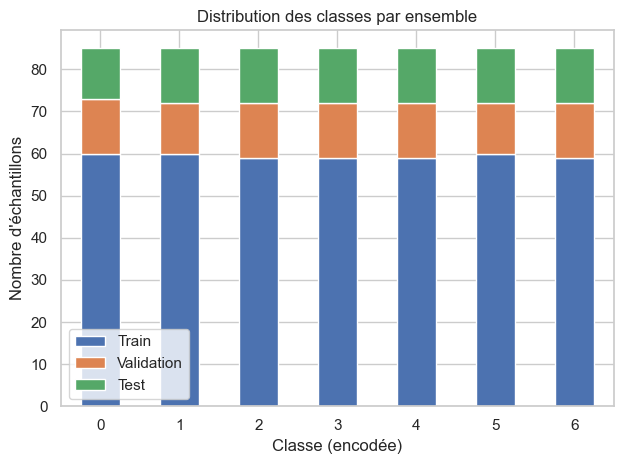

In [4]:
# Division stratifiée des données : 70% train, 15% validation, 15% test
X = raw[['text', 'image_path', 'category']].copy()
y = raw['category_encoded'].values

# Première division : train (70%) vs temp (30%)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=RANDOM_STATE
)

# Seconde division : validation (15%) vs test (15%)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=RANDOM_STATE
)

print('Tailles des ensembles:')
print(f'Train: {len(X_train)} ({len(X_train)/len(X)*100:.1f}%)')
print(f'Validation: {len(X_val)} ({len(X_val)/len(X)*100:.1f}%)')
print(f'Test: {len(X_test)} ({len(X_test)/len(X)*100:.1f}%)')

# Vérification de la stratification
print('\nRépartition par classe:')
train_dist = pd.Series(y_train).value_counts().sort_index()
val_dist = pd.Series(y_val).value_counts().sort_index()
test_dist = pd.Series(y_test).value_counts().sort_index()

distribution_df = pd.DataFrame({
    'Train': train_dist,
    'Validation': val_dist,
    'Test': test_dist
})
distribution_df['Total'] = distribution_df.sum(axis=1)
print(distribution_df)

# Visualisation de la distribution
plt.figure(figsize=(10, 6))
distribution_df[['Train', 'Validation', 'Test']].plot(kind='bar', stacked=True)
plt.title('Distribution des classes par ensemble')
plt.xlabel('Classe (encodée)')
plt.ylabel('Nombre d\'échantillons')
plt.xticks(rotation=0)
plt.legend()
plt.tight_layout()
plt.show()


## 4. Modèles de référence (baseline) et Classification sur caractéristiques textuelles


In [5]:
# Baseline et classification textuelle
from collections import Counter

# Baseline 1: Prédiction majoritaire
most_frequent_class = Counter(y_train).most_common(1)[0][0]
baseline_majority = np.full(len(y_test), most_frequent_class)
baseline_majority_acc = accuracy_score(y_test, baseline_majority)

# Baseline 2: Prédiction aléatoire stratifiée
class_probs = np.bincount(y_train) / len(y_train)
baseline_random = np.random.choice(n_classes, size=len(y_test), p=class_probs)
baseline_random_acc = accuracy_score(y_test, baseline_random)

print('=== BASELINES ===')
print(f'Baseline - Classe majoritaire: {baseline_majority_acc:.3f}')
print(f'Baseline - Aléatoire stratifié: {baseline_random_acc:.3f}')

# Vectorisation TF-IDF des textes
print('\n=== CLASSIFICATION TEXTUELLE ===')
texts_train = X_train['text'].tolist()
texts_val = X_val['text'].tolist()
texts_test = X_test['text'].tolist()

tfidf_vectorizer = TfidfVectorizer(
    max_features=5000,
    ngram_range=(1, 2),
    min_df=2,
    max_df=0.8
)

X_text_train = tfidf_vectorizer.fit_transform(texts_train)
X_text_val = tfidf_vectorizer.transform(texts_val)
X_text_test = tfidf_vectorizer.transform(texts_test)

print(f'Forme TF-IDF train: {X_text_train.shape}')

# Test de plusieurs algorithmes sur les caractéristiques textuelles
text_models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=RANDOM_STATE),
    'Naive Bayes': MultinomialNB(),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=RANDOM_STATE),
    'SVM': SVC(kernel='linear', random_state=RANDOM_STATE)
}

text_results = {}
print('\nEntraînement des modèles textuels...')
for name, model in text_models.items():
    print(f'--- {name} ---')
    model.fit(X_text_train, y_train)
    
    y_pred_val = model.predict(X_text_val)
    y_pred_test = model.predict(X_text_test)
    
    val_acc = accuracy_score(y_val, y_pred_val)
    test_acc = accuracy_score(y_test, y_pred_test)
    
    text_results[name] = {
        'model': model,
        'val_accuracy': val_acc,
        'test_accuracy': test_acc,
        'predictions_test': y_pred_test
    }
    
    print(f'Validation: {val_acc:.3f}, Test: {test_acc:.3f}')

# Meilleur modèle textuel
best_text_model = max(text_results.keys(), key=lambda k: text_results[k]['val_accuracy'])
print(f'\n🏆 Meilleur modèle textuel: {best_text_model}')
print(f'Test accuracy: {text_results[best_text_model]["test_accuracy"]:.3f}')

# Sauvegarde
with open(ARTIFACTS_DIR / 'tfidf_vectorizer.pkl', 'wb') as f:
    pickle.dump(tfidf_vectorizer, f)
print('TF-IDF vectorizer sauvegardé.')


=== BASELINES ===
Baseline - Classe majoritaire: 0.144
Baseline - Aléatoire stratifié: 0.133

=== CLASSIFICATION TEXTUELLE ===
Forme TF-IDF train: (416, 2680)

Entraînement des modèles textuels...
--- Logistic Regression ---
Validation: 0.955, Test: 0.933
--- Naive Bayes ---
Validation: 0.955, Test: 0.922
--- Random Forest ---
Validation: 0.899, Test: 0.856
--- SVM ---
Validation: 0.955, Test: 0.922

🏆 Meilleur modèle textuel: Logistic Regression
Test accuracy: 0.933
TF-IDF vectorizer sauvegardé.


## 5. Classification sur caractéristiques visuelles


In [6]:
# Extraction des caractéristiques MobileNetV2 et classification
print('=== CLASSIFICATION VISUELLE ===')

IMG_SIZE = (224, 224)
base_model = MobileNetV2(weights='imagenet', include_top=False, pooling='avg',
                        input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))

def load_and_preprocess_image(image_path: str):
    """Charge et prétraite une image pour MobileNetV2"""
    try:
        img = keras_image.load_img(image_path, target_size=IMG_SIZE)
        x = keras_image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = mobilenet_preprocess(x)
        return x
    except Exception as e:
        print(f'Erreur: {image_path}: {e}')
        return None

def extract_features_batch(image_paths, batch_size=32):
    """Extraction par batch pour optimiser la mémoire"""
    features = []
    
    for i in range(0, len(image_paths), batch_size):
        batch_paths = image_paths[i:i+batch_size]
        batch_images = []
        
        for path in batch_paths:
            img = load_and_preprocess_image(path)
            if img is not None:
                batch_images.append(img[0])
            else:
                batch_images.append(np.zeros((IMG_SIZE[0], IMG_SIZE[1], 3)))
        
        if batch_images:
            batch_array = np.array(batch_images)
            batch_features = base_model.predict(batch_array, verbose=0)
            features.extend(batch_features)
        
        if (i + batch_size) % 100 == 0 or i + batch_size >= len(image_paths):
            print(f'Traité {min(i + batch_size, len(image_paths))}/{len(image_paths)} images')
    
    return np.array(features)

# Extraction des caractéristiques pour tous les ensembles
print('Extraction des caractéristiques...')
X_img_train = extract_features_batch(X_train['image_path'].tolist())
X_img_val = extract_features_batch(X_val['image_path'].tolist())
X_img_test = extract_features_batch(X_test['image_path'].tolist())

print(f'Formes: Train {X_img_train.shape}, Val {X_img_val.shape}, Test {X_img_test.shape}')

# Normalisation
scaler_img = StandardScaler()
X_img_train_scaled = scaler_img.fit_transform(X_img_train)
X_img_val_scaled = scaler_img.transform(X_img_val)
X_img_test_scaled = scaler_img.transform(X_img_test)

# Test de modèles classiques sur les caractéristiques visuelles
image_models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=RANDOM_STATE),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=RANDOM_STATE),
    'SVM': SVC(kernel='rbf', random_state=RANDOM_STATE)
}

image_results = {}
print('\nEntraînement des modèles visuels...')
for name, model in image_models.items():
    print(f'--- {name} ---')
    model.fit(X_img_train_scaled, y_train)
    
    y_pred_val = model.predict(X_img_val_scaled)
    y_pred_test = model.predict(X_img_test_scaled)
    
    val_acc = accuracy_score(y_val, y_pred_val)
    test_acc = accuracy_score(y_test, y_pred_test)
    
    image_results[name] = {
        'val_accuracy': val_acc,
        'test_accuracy': test_acc,
        'predictions_test': y_pred_test
    }
    
    print(f'Validation: {val_acc:.3f}, Test: {test_acc:.3f}')

# Meilleur modèle visuel
best_image_model = max(image_results.keys(), key=lambda k: image_results[k]['val_accuracy'])
print(f'\n🏆 Meilleur modèle visuel: {best_image_model}')
print(f'Test accuracy: {image_results[best_image_model]["test_accuracy"]:.3f}')

# Sauvegarde
with open(ARTIFACTS_DIR / 'image_scaler.pkl', 'wb') as f:
    pickle.dump(scaler_img, f)
print('Image scaler sauvegardé.')


=== CLASSIFICATION VISUELLE ===


2025-09-29 23:30:26.852581: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3 Pro
2025-09-29 23:30:26.852607: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 36.00 GB
2025-09-29 23:30:26.852610: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 14.04 GB
2025-09-29 23:30:26.852625: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-09-29 23:30:26.852634: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Extraction des caractéristiques...


2025-09-29 23:30:28.071885: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


Traité 416/416 images
Traité 89/89 images
Traité 90/90 images
Formes: Train (416, 1280), Val (89, 1280), Test (90, 1280)

Entraînement des modèles visuels...
--- Logistic Regression ---
Validation: 0.831, Test: 0.844
--- Random Forest ---
Validation: 0.831, Test: 0.767
--- SVM ---
Validation: 0.809, Test: 0.833

🏆 Meilleur modèle visuel: Logistic Regression
Test accuracy: 0.844
Image scaler sauvegardé.


🎯 FINE-TUNING DE MOBILENETV2

🏗️ CRÉATION DU MODÈLE FINE-TUNÉ...

📊 ARCHITECTURE MOBILENETV2 (155 couches):
 0. input_layer_1        - Trainable: True
 1. Conv1                - Trainable: True
 2. bn_Conv1             - Trainable: True
 3. Conv1_relu           - Trainable: True
 4. expanded_conv_depthwise - Trainable: True
 5. expanded_conv_depthwise_BN - Trainable: True
 6. expanded_conv_depthwise_relu - Trainable: True
 7. expanded_conv_project - Trainable: True
 8. expanded_conv_project_BN - Trainable: True
 9. block_1_expand       - Trainable: True
10. block_1_expand_BN    - Trainable: True
11. block_1_expand_relu  - Trainable: True
12. block_1_pad          - Trainable: True
13. block_1_depthwise    - Trainable: True
14. block_1_depthwise_BN - Trainable: True
15. block_1_depthwise_relu - Trainable: True
16. block_1_project      - Trainable: True
17. block_1_project_BN   - Trainable: True
18. block_2_expand       - Trainable: True
19. block_2_expand_BN    - Trainable: True
20. bloc

Model: "MobileNetV2_FineTuned"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide (TrueDivide)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract (Subtract)             │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 1280)           │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1280)           │         5,120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       655,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 7)              │         1,799 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,055,175 (11.65 MB)

 Trainable params: 2,153,095 (8.21 MB)

 Non-trainable params: 902,080 (3.44 MB)


🚀 CONFIGURATION D'ENTRAÎNEMENT POUR FINE-TUNING...

🔧 PRÉPARATION DES DONNÉES...
Préparation des images pour le fine-tuning...
✅ Données préparées: Train=(416, 224, 224, 3), Val=(89, 224, 224, 3), Test=(90, 224, 224, 3)
Range des valeurs d'entrée: [-1.00, 1.00]
Distribution des labels: [60 60 59 59 59 60 59]

🔥 ENTRAÎNEMENT DU MODÈLE FINE-TUNÉ...

📚 PHASE 1: Entraînement de la tête de classification...
Epoch 1/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.1961 - loss: 2.6740
Epoch 1: val_accuracy improved from None to 0.13483, saving model to /Users/laureendademeule/Documents/Projets/P6/data/artifacts/mobilenetv2_finetuned_best.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 10s 170ms/step - accuracy: 0.2644 - loss: 2.3907 - val_accuracy: 0.1348 - val_loss: 2.8251
Epoch 2/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.5382 - loss: 1.4199
Epoch 2: val_accuracy did not improve from 0.13483
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step - accuracy: 0.5216 - loss: 1.4157 - val_accuracy: 0.1348 - val_loss: 2.6610
Epoch 3/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.6624 - loss: 1.0231
Epoch 3: val_accuracy did not improve from 0.13483
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step - accuracy: 0.6587 - loss: 1.0466 - val_accuracy: 0.1348 - val_loss: 3.1326
Epoch 4/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.7672 - loss: 0.8200
Epoch 4: val_accuracy improved from 0.13483 to 0.14607, saving model to /Users/laureendademeule/Documents/Projets/P6/data/artifacts/mobilenetv2_finetuned_best.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 78ms/step - accuracy: 0.7644 - loss: 0.8217 - val_accuracy: 0.1461 - val_loss: 2.8037
Epoch 5/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.8085 - loss: 0.7088
Epoch 5: val_accuracy did not improve from 0.14607
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 78ms/step - accuracy: 0.8053 - loss: 0.7104 - val_accuracy: 0.1348 - val_loss: 2.8920
Epoch 6/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.8293 - loss: 0.6165
Epoch 6: val_accuracy did not improve from 0.14607
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step - accuracy: 0.8582 - loss: 0.5821 - val_accuracy: 0.1348 - val_loss: 2.9224
Epoch 7/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.8894 - loss: 0.5274
Epoch 7: val_accuracy did not improve from 0.14607
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step - accuracy: 0.8870 - loss: 0.5216 - val_accuracy: 0.1348 - val_loss: 2.7576
Epoch 8/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.9407 - loss: 0.4137
Epoch 8: val_accuracy did not improve from 

26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 80ms/step - accuracy: 0.9688 - loss: 0.2818 - val_accuracy: 0.1573 - val_loss: 3.2552
Epoch 12/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.9616 - loss: 0.2880
Epoch 12: val_accuracy did not improve from 0.15730
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step - accuracy: 0.9760 - loss: 0.2713 - val_accuracy: 0.1573 - val_loss: 3.5198
Epoch 13/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.9847 - loss: 0.2323
Epoch 13: val_accuracy did not improve from 0.15730
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step - accuracy: 0.9808 - loss: 0.2391 - val_accuracy: 0.1573 - val_loss: 3.5233
Epoch 14/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.9874 - loss: 0.2236
Epoch 14: val_accuracy did not improve from 0.15730
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step - accuracy: 0.9904 - loss: 0.2209 - val_accuracy: 0.1461 - val_loss: 4.1430
Epoch 15/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.9937 - loss: 0.1993
Epoch 15: val_accuracy did not impro

26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 87ms/step - accuracy: 0.9976 - loss: 0.1720 - val_accuracy: 0.2022 - val_loss: 4.0990
Epoch 18/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 1.0000 - loss: 0.1587
Epoch 18: val_accuracy improved from 0.20225 to 0.21348, saving model to /Users/laureendademeule/Documents/Projets/P6/data/artifacts/mobilenetv2_finetuned_best.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 77ms/step - accuracy: 1.0000 - loss: 0.1591 - val_accuracy: 0.2135 - val_loss: 3.9590
Epoch 19/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 1.0000 - loss: 0.1497
Epoch 19: val_accuracy improved from 0.21348 to 0.22472, saving model to /Users/laureendademeule/Documents/Projets/P6/data/artifacts/mobilenetv2_finetuned_best.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 79ms/step - accuracy: 1.0000 - loss: 0.1539 - val_accuracy: 0.2247 - val_loss: 3.9261
Epoch 20/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.9914 - loss: 0.1714
Epoch 20: val_accuracy did not improve from 0.22472
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step - accuracy: 0.9952 - loss: 0.1604 - val_accuracy: 0.2135 - val_loss: 3.7458
Restoring model weights from the end of the best epoch: 19.

🎯 PHASE 2: Fine-tuning des couches MobileNetV2...

Epoch 1: LearningRateScheduler setting learning rate to 0.0001.
Epoch 1/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.9861 - loss: 0.1961
Epoch 1: val_accuracy did not improve from 0.22472
26/26 ━━━━━━━━━━━━━━━━━━━━ 12s 251ms/step - accuracy: 0.9784 - loss: 0.2298 - val_accuracy: 0.1573 - val_loss: 5.2635 - learning_rate: 1.0000e-04

Epoch 2: LearningRateScheduler setting learning rate to 9.990232305719945e-05.
Epoch 2/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.9627 - loss: 0.2423
Epoch 2

26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 88ms/step - accuracy: 0.9976 - loss: 0.1561 - val_accuracy: 0.2584 - val_loss: 5.1307 - learning_rate: 9.6524e-05

Epoch 8: LearningRateScheduler setting learning rate to 9.528893909706797e-05.
Epoch 8/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.9986 - loss: 0.1510
Epoch 8: val_accuracy improved from 0.25843 to 0.28090, saving model to /Users/laureendademeule/Documents/Projets/P6/data/artifacts/mobilenetv2_finetuned_best.h5



Epoch 8: ReduceLROnPlateau reducing learning rate to 4.7644469304941595e-05.
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 89ms/step - accuracy: 0.9976 - loss: 0.1476 - val_accuracy: 0.2809 - val_loss: 5.1608 - learning_rate: 9.5289e-05

Epoch 9: LearningRateScheduler setting learning rate to 9.387718066217124e-05.
Epoch 9/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.9722 - loss: 0.1703
Epoch 9: val_accuracy did not improve from 0.28090
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 76ms/step - accuracy: 0.9856 - loss: 0.1612 - val_accuracy: 0.2697 - val_loss: 5.4825 - learning_rate: 9.3877e-05

Epoch 10: LearningRateScheduler setting learning rate to 9.229423231234974e-05.
Epoch 10/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.9924 - loss: 0.1539
Epoch 10: val_accuracy did not improve from 0.28090
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 77ms/step - accuracy: 0.9952 - loss: 0.1515 - val_accuracy: 0.2697 - val_loss: 5.5090 - learning_rate: 9.2294e-05

Epoch 11: LearningRateScheduler setting learning rate 

26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 88ms/step - accuracy: 1.0000 - loss: 0.1104 - val_accuracy: 0.2921 - val_loss: 4.7017 - learning_rate: 6.8722e-05

Epoch 21: LearningRateScheduler setting learning rate to 6.57963412215599e-05.
Epoch 21/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 1.0000 - loss: 0.1096
Epoch 21: val_accuracy did not improve from 0.29213
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step - accuracy: 1.0000 - loss: 0.1094 - val_accuracy: 0.2921 - val_loss: 4.5499 - learning_rate: 6.5796e-05

Epoch 22: LearningRateScheduler setting learning rate to 6.281014941466031e-05.
Epoch 22/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 1.0000 - loss: 0.1100
Epoch 22: val_accuracy did not improve from 0.29213
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 78ms/step - accuracy: 1.0000 - loss: 0.1094 - val_accuracy: 0.2921 - val_loss: 4.5658 - learning_rate: 6.2810e-05

Epoch 23: LearningRateScheduler setting learning rate to 5.977537507199338e-05.
Epoch 23/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/ste

26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - accuracy: 1.0000 - loss: 0.1087 - val_accuracy: 0.3146 - val_loss: 4.4769 - learning_rate: 5.3608e-05

Epoch 26: LearningRateScheduler setting learning rate to 5.05e-05.
Epoch 26/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 1.0000 - loss: 0.1081
Epoch 26: val_accuracy did not improve from 0.31461
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step - accuracy: 1.0000 - loss: 0.1084 - val_accuracy: 0.3146 - val_loss: 4.3384 - learning_rate: 5.0500e-05

Epoch 27: LearningRateScheduler setting learning rate to 4.739186928329899e-05.
Epoch 27/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 1.0000 - loss: 0.1087
Epoch 27: val_accuracy did not improve from 0.31461
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step - accuracy: 1.0000 - loss: 0.1086 - val_accuracy: 0.3034 - val_loss: 4.2405 - learning_rate: 4.7392e-05

Epoch 28: LearningRateScheduler setting learning rate to 4.429600493856695e-05.
Epoch 28/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy

26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 83ms/step - accuracy: 1.0000 - loss: 0.1070 - val_accuracy: 0.3258 - val_loss: 3.7664 - learning_rate: 2.3977e-05

Epoch 36: LearningRateScheduler setting learning rate to 2.1404630011522586e-05.
Epoch 36/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 1.0000 - loss: 0.1069
Epoch 36: val_accuracy did not improve from 0.32584
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step - accuracy: 1.0000 - loss: 0.1071 - val_accuracy: 0.3258 - val_loss: 3.7228 - learning_rate: 2.1405e-05

Epoch 37: LearningRateScheduler setting learning rate to 1.8947512507439858e-05.
Epoch 37/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 1.0000 - loss: 0.1070
Epoch 37: val_accuracy improved from 0.32584 to 0.33708, saving model to /Users/laureendademeule/Documents/Projets/P6/data/artifacts/mobilenetv2_finetuned_best.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 79ms/step - accuracy: 1.0000 - loss: 0.1069 - val_accuracy: 0.3371 - val_loss: 3.6715 - learning_rate: 1.8948e-05

Epoch 38: LearningRateScheduler setting learning rate to 1.661491825652991e-05.
Epoch 38/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 1.0000 - loss: 0.1067
Epoch 38: val_accuracy improved from 0.33708 to 0.34831, saving model to /Users/laureendademeule/Documents/Projets/P6/data/artifacts/mobilenetv2_finetuned_best.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 80ms/step - accuracy: 1.0000 - loss: 0.1069 - val_accuracy: 0.3483 - val_loss: 3.6215 - learning_rate: 1.6615e-05

Epoch 39: LearningRateScheduler setting learning rate to 1.441605294264014e-05.
Epoch 39/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 1.0000 - loss: 0.1073
Epoch 39: val_accuracy did not improve from 0.34831
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step - accuracy: 1.0000 - loss: 0.1071 - val_accuracy: 0.3371 - val_loss: 3.5571 - learning_rate: 1.4416e-05

Epoch 40: LearningRateScheduler setting learning rate to 1.235959448259844e-05.
Epoch 40/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 1.0000 - loss: 0.1074
Epoch 40: val_accuracy did not improve from 0.34831
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step - accuracy: 1.0000 - loss: 0.1073 - val_accuracy: 0.3371 - val_loss: 3.4911 - learning_rate: 1.2360e-05

Epoch 41: LearningRateScheduler setting learning rate to 1.0453658778440109e-05.
Epoch 41/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/s

26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 79ms/step - accuracy: 1.0000 - loss: 0.1068 - val_accuracy: 0.3596 - val_loss: 3.4403 - learning_rate: 1.0454e-05

Epoch 42: LearningRateScheduler setting learning rate to 8.705767687650266e-06.
Epoch 42/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 1.0000 - loss: 0.1073
Epoch 42: val_accuracy improved from 0.35955 to 0.37079, saving model to /Users/laureendademeule/Documents/Projets/P6/data/artifacts/mobilenetv2_finetuned_best.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 79ms/step - accuracy: 1.0000 - loss: 0.1071 - val_accuracy: 0.3708 - val_loss: 3.4025 - learning_rate: 8.7058e-06

Epoch 43: LearningRateScheduler setting learning rate to 7.122819337828753e-06.
Epoch 43/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 1.0000 - loss: 0.1069
Epoch 43: val_accuracy did not improve from 0.37079
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step - accuracy: 1.0000 - loss: 0.1069 - val_accuracy: 0.3708 - val_loss: 3.3641 - learning_rate: 7.1228e-06

Epoch 44: LearningRateScheduler setting learning rate to 5.711060902932042e-06.
Epoch 44/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 1.0000 - loss: 0.1069
Epoch 44: val_accuracy did not improve from 0.37079
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step - accuracy: 1.0000 - loss: 0.1069 - val_accuracy: 0.3708 - val_loss: 3.3350 - learning_rate: 5.7111e-06

Epoch 45: LearningRateScheduler setting learning rate to 4.476063948531558e-06.
Epoch 45/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/st

26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 80ms/step - accuracy: 1.0000 - loss: 0.1070 - val_accuracy: 0.3933 - val_loss: 3.2713 - learning_rate: 3.4227e-06

Epoch 47: LearningRateScheduler setting learning rate to 2.5551335241327673e-06.
Epoch 47/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 1.0000 - loss: 0.1067
Epoch 47: val_accuracy did not improve from 0.39326
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step - accuracy: 1.0000 - loss: 0.1066 - val_accuracy: 0.3933 - val_loss: 3.2444 - learning_rate: 2.5551e-06

Epoch 48: LearningRateScheduler setting learning rate to 1.8767810889299083e-06.
Epoch 48/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 1.0000 - loss: 0.1072
Epoch 48: val_accuracy did not improve from 0.39326
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step - accuracy: 1.0000 - loss: 0.1070 - val_accuracy: 0.3933 - val_loss: 3.2014 - learning_rate: 1.8768e-06

Epoch 49: LearningRateScheduler setting learning rate to 1.3903222849333507e-06.
Epoch 49/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms

26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 78ms/step - accuracy: 1.0000 - loss: 0.1065 - val_accuracy: 0.4045 - val_loss: 3.1734 - learning_rate: 1.3903e-06

Epoch 50: LearningRateScheduler setting learning rate to 1.0976769428005578e-06.
Epoch 50/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 1.0000 - loss: 0.1068
Epoch 50: val_accuracy improved from 0.40449 to 0.41573, saving model to /Users/laureendademeule/Documents/Projets/P6/data/artifacts/mobilenetv2_finetuned_best.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 78ms/step - accuracy: 1.0000 - loss: 0.1070 - val_accuracy: 0.4157 - val_loss: 3.1441 - learning_rate: 1.0977e-06
Restoring model weights from the end of the best epoch: 50.

🏆 ÉVALUATION DU MODÈLE FINE-TUNÉ
Évaluation du modèle fine-tuné sur le test set...
🎯 MobileNetV2 Fine-Tuné - Test Accuracy: 0.389 (38.9%)
Predictions shape: (90, 7)
Predicted classes range: [0, 6]
True classes range: [0, 6]
Unique predicted classes: [0 1 2 3 4 5 6]

📈 COMPARAISON AVEC FEATURE EXTRACTION:
  Feature Extraction: 0.844 (84.4%)
  Fine-Tuning: 0.389 (38.9%)
  Amélioration: -0.456 (-53.9%)
ℹ️ Le fine-tuning nécessite peut-être plus d'ajustements

💾 Modèle fine-tuné sauvegardé: /Users/laureendademeule/Documents/Projets/P6/data/artifacts/mobilenetv2_finetuned_final.keras

📊 ANALYSE DU FINE-TUNING...


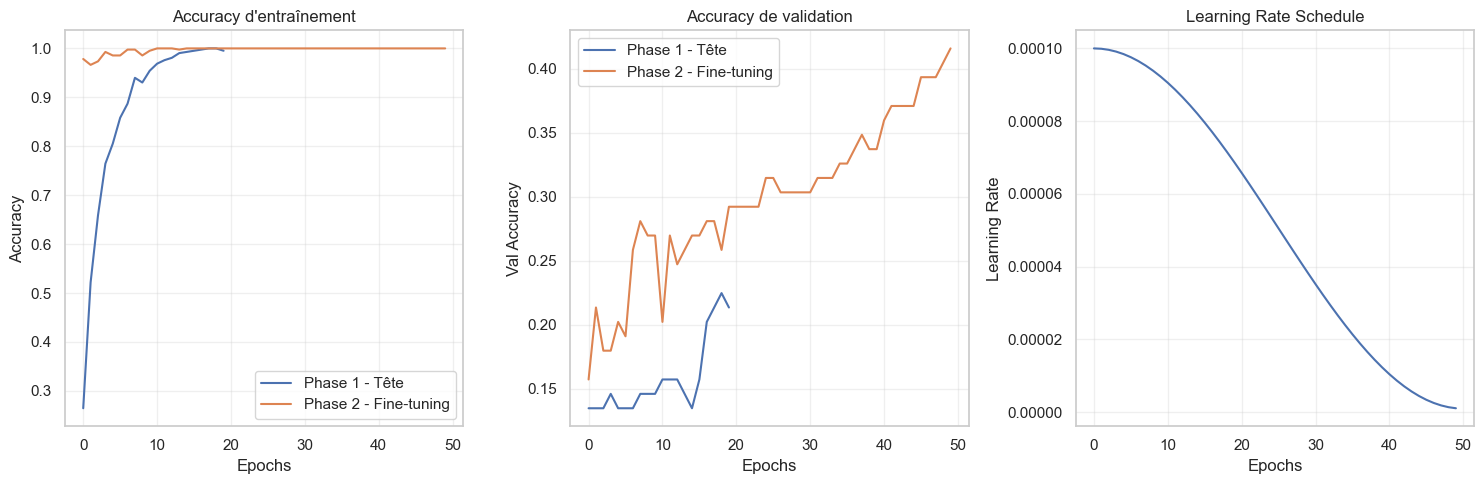

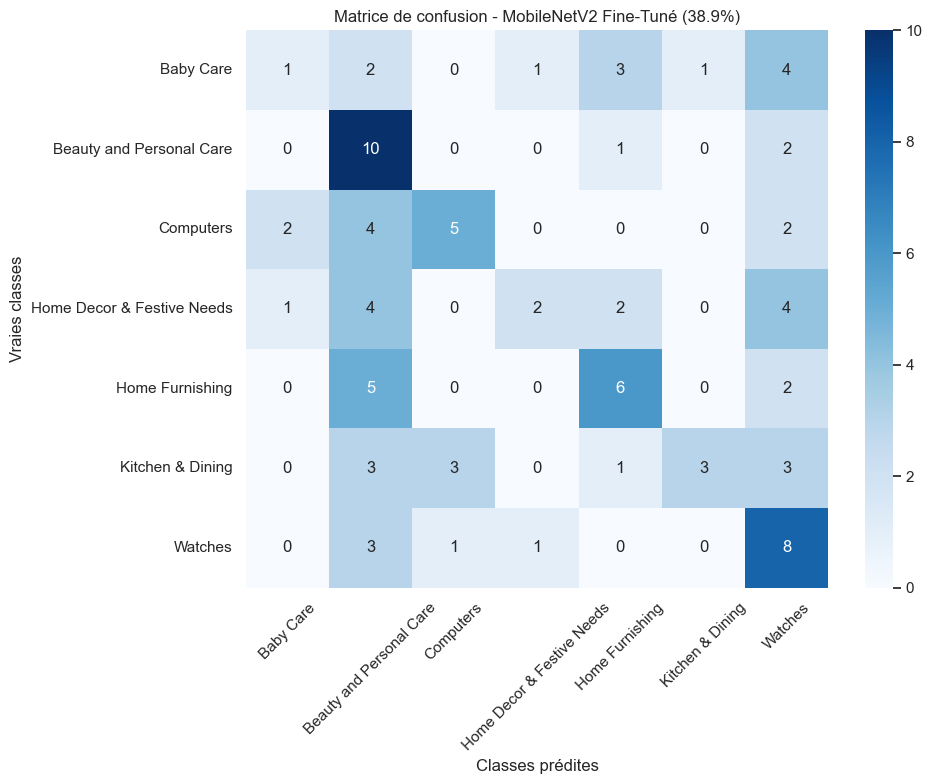


✅ FINE-TUNING MOBILENETV2 TERMINÉ!

🔄 MISE À JOUR DU CLASSEMENT AVEC FINE-TUNING...

🏆 CLASSEMENT AVEC FINE-TUNING:
 1. Text - Logistic Regression          : 0.933 (93.3%) 🥇 MEILLEUR
 2. Text - Naive Bayes                  : 0.922 (92.2%) 🥈 Top 3
 3. Text - SVM                          : 0.922 (92.2%) 🥈 Top 3
 4. Text - Random Forest                : 0.856 (85.6%) 
 5. Image - Logistic Regression         : 0.844 (84.4%) 
 6. Image - SVM                         : 0.833 (83.3%) 
 7. Image - Random Forest               : 0.767 (76.7%) 
 8. Image - MobileNetV2 Fine-Tuné       : 0.389 (38.9%) 
 9. Baseline - Majoritaire              : 0.144 (14.4%) 
10. Baseline - Aléatoire                : 0.133 (13.3%) 


In [7]:
# =============================================================================
# FINE-TUNING DE MOBILENETV2 : VERSION OPTIMISÉE
# =============================================================================

print('🎯 FINE-TUNING DE MOBILENETV2')

# =============================================================================
# 1. CONFIGURATION DU FINE-TUNING
# =============================================================================

def create_finetuned_mobilenet_model(n_classes, unfreeze_layers=20):
    """Crée un modèle MobileNetV2 avec fine-tuning optimisé"""

    # Base MobileNetV2 pré-entraîné
    base_model = MobileNetV2(
        weights='imagenet',
        include_top=False,
        pooling='avg',
        input_shape=(224, 224, 3)
    )

    # Afficher l'architecture de base
    print(f'\n📊 ARCHITECTURE MOBILENETV2 ({len(base_model.layers)} couches):')
    for i, layer in enumerate(base_model.layers):
        print(f'{i:2d}. {layer.name:<20} - Trainable: {layer.trainable}')

    # =========================================================================
    # STRATÉGIE DE FINE-TUNING : Dégeler les couches supérieures
    # =========================================================================

    # Étape 1 : Toutes les couches gelées (feature extraction)
    base_model.trainable = False

    # Étape 2 : Dégeler les dernières couches (fine-tuning)
    for layer in base_model.layers[-unfreeze_layers:]:
        layer.trainable = True
        print(f'✅ Dégelé: {layer.name}')

    print(f'\n🔓 Couches dégelées: {unfreeze_layers}/{len(base_model.layers)}')
    print(f'🔒 Couches gelées: {len(base_model.layers) - unfreeze_layers}/{len(base_model.layers)}')

    # =========================================================================
    # CONSTRUCTION DU MODÈLE COMPLET
    # =========================================================================

    # Entrée du modèle
    inputs = tf.keras.Input(shape=(224, 224, 3))

    # Prétraitement MobileNetV2
    x = mobilenet_preprocess(inputs)

    # Features MobileNetV2 (partiellement fine-tuné)
    x = base_model(x, training=True)  # training=True important pour le fine-tuning

    # =========================================================================
    # TÊTE DE CLASSIFICATION OPTIMISÉE
    # =========================================================================

    # Couches de classification
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dense(512, activation='relu',
                            kernel_regularizer=tf.keras.regularizers.l2(0.0001))(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.3)(x)

    x = tf.keras.layers.Dense(256, activation='relu',
                            kernel_regularizer=tf.keras.regularizers.l2(0.0001))(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.2)(x)

    # Couche de sortie
    outputs = tf.keras.layers.Dense(n_classes, activation='softmax')(x)

    # Création du modèle
    model = tf.keras.Model(inputs, outputs, name='MobileNetV2_FineTuned')

    return model, base_model

# =============================================================================
# 2. CRÉATION ET COMPILATION DU MODÈLE
# =============================================================================

print('\n🏗️ CRÉATION DU MODÈLE FINE-TUNÉ...')

# Nombre de couches à dégeler (optimisé pour votre dataset)
UNFREEZE_LAYERS = 25  # Dégeler les 25 dernières couches

# Création du modèle
finetuned_model, base_model = create_finetuned_mobilenet_model(n_classes, UNFREEZE_LAYERS)

# Affichage du résumé
print(f'\n📋 RÉSUMÉ DU MODÈLE:')
print(f'✅ Modèle créé avec {finetuned_model.count_params():,} paramètres')
print(f'🔓 Paramètres entraînables: {sum([tf.keras.backend.count_params(w) for w in finetuned_model.trainable_weights]):,}')
print(f'🔒 Paramètres gelés: {sum([tf.keras.backend.count_params(w) for w in finetuned_model.non_trainable_weights]):,}')

finetuned_model.summary()

# =============================================================================
# 3. CONFIGURATION D'ENTRAÎNEMENT OPTIMISÉE POUR FINE-TUNING
# =============================================================================

print('\n🚀 CONFIGURATION D\'ENTRAÎNEMENT POUR FINE-TUNING...')

# Learning rate réduit pour le fine-tuning
INITIAL_LR = 1e-4  # Plus faible qu'en feature extraction
FINAL_LR = 1e-6

def cosine_decay_scheduler(epoch, lr):
    """Scheduler de décroissance cosinus pour fine-tuning stable"""
    epochs = 50
    return FINAL_LR + 0.5 * (INITIAL_LR - FINAL_LR) * (1 + np.cos(np.pi * epoch / epochs))

# Optimiseur avec scheduler
optimizer = tf.keras.optimizers.Adam(learning_rate=INITIAL_LR)

# Callbacks optimisés pour fine-tuning
callbacks_finetuning = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_accuracy',
        patience=15,  # Moins de patience pour éviter l'overfitting
        restore_best_weights=True,
        verbose=1,
        min_delta=0.001
    ),
    tf.keras.callbacks.ModelCheckpoint(
        ARTIFACTS_DIR / 'mobilenetv2_finetuned_best.h5',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    ),
    tf.keras.callbacks.LearningRateScheduler(cosine_decay_scheduler, verbose=1),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=FINAL_LR,
        verbose=1
    )
]

# Compilation avec loss adapté
finetuned_model.compile(
    optimizer=optimizer,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# =============================================================================
# 4. PRÉPARATION DES DONNÉES POUR FINE-TUNING
# =============================================================================

print('\n🔧 PRÉPARATION DES DONNÉES...')

def load_and_preprocess_image_finetuning(image_path):
    """Prétraite les images pour le fine-tuning MobileNetV2"""
    try:
        img = keras_image.load_img(image_path, target_size=(224, 224))
        x = keras_image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = mobilenet_preprocess(x)
        return x[0]  # Retourner l'image prétraitée directement
    except Exception as e:
        print(f'Erreur: {image_path}: {e}')
        return np.zeros((224, 224, 3))

# Préparation des datasets
print('Préparation des images pour le fine-tuning...')
X_img_train_ft = np.array([load_and_preprocess_image_finetuning(path) for path in X_train['image_path'].tolist()])
X_img_val_ft = np.array([load_and_preprocess_image_finetuning(path) for path in X_val['image_path'].tolist()])
X_img_test_ft = np.array([load_and_preprocess_image_finetuning(path) for path in X_test['image_path'].tolist()])

print(f'✅ Données préparées: Train={X_img_train_ft.shape}, Val={X_img_val_ft.shape}, Test={X_img_test_ft.shape}')

# Vérification des données
print(f'Range des valeurs d\'entrée: [{X_img_train_ft.min():.2f}, {X_img_train_ft.max():.2f}]')
print(f'Distribution des labels: {np.bincount(y_train)}')

# =============================================================================
# 5. ENTRAÎNEMENT DU MODÈLE FINE-TUNÉ
# =============================================================================

print('\n🔥 ENTRAÎNEMENT DU MODÈLE FINE-TUNÉ...')

# Entraînement en deux phases
print('\n📚 PHASE 1: Entraînement de la tête de classification...')
history_phase1 = finetuned_model.fit(
    X_img_train_ft, y_train,
    validation_data=(X_img_val_ft, y_val),
    epochs=20,
    batch_size=16,  # Batch plus petit pour la stabilité
    callbacks=[callbacks_finetuning[0], callbacks_finetuning[1]],  # Seulement early stopping et checkpoint
    verbose=1
)

print('\n🎯 PHASE 2: Fine-tuning des couches MobileNetV2...')
# Dégeler les couches pour le fine-tuning
for layer in base_model.layers[-UNFREEZE_LAYERS:]:
    layer.trainable = True

# Recompiler avec le scheduler de learning rate
finetuned_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=INITIAL_LR),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history_phase2 = finetuned_model.fit(
    X_img_train_ft, y_train,
    validation_data=(X_img_val_ft, y_val),
    epochs=50,
    batch_size=16,
    callbacks=callbacks_finetuning,
    verbose=1
)

# =============================================================================
# 6. ÉVALUATION ET COMPARAISON
# =============================================================================

print('\n🏆 ÉVALUATION DU MODÈLE FINE-TUNÉ')

# Charger le meilleur modèle
finetuned_model.load_weights(ARTIFACTS_DIR / 'mobilenetv2_finetuned_best.h5')

# Évaluation sur le test set
print('Évaluation du modèle fine-tuné sur le test set...')
test_predictions_ft = finetuned_model.predict(X_img_test_ft, verbose=0)
test_pred_classes_ft = np.argmax(test_predictions_ft, axis=1)
finetuned_accuracy = accuracy_score(y_test, test_pred_classes_ft)

print(f'🎯 MobileNetV2 Fine-Tuné - Test Accuracy: {finetuned_accuracy:.3f} ({finetuned_accuracy*100:.1f}%)')

# Vérification des prédictions
print(f'Predictions shape: {test_predictions_ft.shape}')
print(f'Predicted classes range: [{test_pred_classes_ft.min()}, {test_pred_classes_ft.max()}]')
print(f'True classes range: [{y_test.min()}, {y_test.max()}]')
print(f'Unique predicted classes: {np.unique(test_pred_classes_ft)}')

# Comparaison avec le modèle feature extraction
baseline_image_acc = image_results['Logistic Regression']['test_accuracy']

print(f'\n📈 COMPARAISON AVEC FEATURE EXTRACTION:')
print(f'  Feature Extraction: {baseline_image_acc:.3f} ({baseline_image_acc*100:.1f}%)')
print(f'  Fine-Tuning: {finetuned_accuracy:.3f} ({finetuned_accuracy*100:.1f}%)')
print(f'  Amélioration: {finetuned_accuracy - baseline_image_acc:+.3f} ({(finetuned_accuracy - baseline_image_acc)/baseline_image_acc*100:+.1f}%)')

if finetuned_accuracy > baseline_image_acc + 0.05:
    print('🎉 SUCCÈS! Le fine-tuning améliore significativement les performances!')
elif finetuned_accuracy > baseline_image_acc:
    print('✅ AMÉLIORATION! Le fine-tuning apporte un gain modéré')
else:
    print('ℹ️ Le fine-tuning nécessite peut-être plus d\'ajustements')

# Sauvegarde du modèle final
finetuned_model.save(ARTIFACTS_DIR / 'mobilenetv2_finetuned_final.keras')
print(f'\n💾 Modèle fine-tuné sauvegardé: {ARTIFACTS_DIR}/mobilenetv2_finetuned_final.keras')

# =============================================================================
# 7. ANALYSE DÉTAILLÉE DU FINE-TUNING
# =============================================================================

print('\n📊 ANALYSE DU FINE-TUNING...')

# Courbes d'apprentissage
plt.figure(figsize=(15, 5))

# Accuracy
plt.subplot(1, 3, 1)
plt.plot(history_phase1.history['accuracy'], label='Phase 1 - Tête')
plt.plot(history_phase2.history['accuracy'], label='Phase 2 - Fine-tuning')
plt.title('Accuracy d\'entraînement')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)

# Validation Accuracy
plt.subplot(1, 3, 2)
plt.plot(history_phase1.history['val_accuracy'], label='Phase 1 - Tête')
plt.plot(history_phase2.history['val_accuracy'], label='Phase 2 - Fine-tuning')
plt.title('Accuracy de validation')
plt.xlabel('Epochs')
plt.ylabel('Val Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)

# Learning Rate
plt.subplot(1, 3, 3)
lrs = [cosine_decay_scheduler(i, INITIAL_LR) for i in range(50)]
plt.plot(lrs)
plt.title('Learning Rate Schedule')
plt.xlabel('Epochs')
plt.ylabel('Learning Rate')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


# Matrice de confusion
plt.figure(figsize=(10, 8))
cm_ft = confusion_matrix(y_test, test_pred_classes_ft)
sns.heatmap(cm_ft, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title(f'Matrice de confusion - MobileNetV2 Fine-Tuné ({finetuned_accuracy:.1%})')
plt.ylabel('Vraies classes')
plt.xlabel('Classes prédites')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print('\n' + '='*80)
print('✅ FINE-TUNING MOBILENETV2 TERMINÉ!')
print('='*80)

# Mise à jour du classement
print('\n🔄 MISE À JOUR DU CLASSEMENT AVEC FINE-TUNING...')

# Créer le classement avec fine-tuning
all_results_finetuning = {}

# Baselines
all_results_finetuning['Baseline - Majoritaire'] = baseline_majority_acc
all_results_finetuning['Baseline - Aléatoire'] = baseline_random_acc

# Modèles textuels
for name, results in text_results.items():
    all_results_finetuning[f'Text - {name}'] = results['test_accuracy']

# Modèles visuels
for name, results in image_results.items():
    all_results_finetuning[f'Image - {name}'] = results['test_accuracy']

# Fine-tuning
all_results_finetuning['Image - MobileNetV2 Fine-Tuné'] = finetuned_accuracy

sorted_finetuning = dict(sorted(all_results_finetuning.items(), key=lambda x: x[1], reverse=True))

print('\n🏆 CLASSEMENT AVEC FINE-TUNING:')
for i, (name, accuracy) in enumerate(sorted_finetuning.items(), 1):
    status = "🥇 MEILLEUR" if accuracy == max(sorted_finetuning.values()) else "🥈 Top 3" if i <= 3 else ""
    print(f"{i:2d}. {name:<35} : {accuracy:.3f} ({accuracy*100:.1f}%) {status}")

## 6. Deep Learning et fusion multimodale

🚀 CRÉATION DU MODÈLE MULTIMODAL P6 AVANCÉ (TEXTE + IMAGES)
🔧 Préparation des données multimodales...
📊 Dimensions: Texte=2680, Images=1280, Total=3960
✅ Modèle multimodal créé avec 4,612,327 paramètres


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ text_input          │ (None, 2680)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ image_input         │ (None, 1280)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 2680)      │     10,720 │ text_input[0][0]  │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1280)      │      5,120 │ image_input[0][0] │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 1024)      │  2,745,344 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 512)       │    655,872 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1024)      │      4,096 │ dense_3[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 512)       │      2,048 │ dense_5[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 1024)      │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 512)       │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 512)       │    524,800 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 256)       │    131,328 │ dropout_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 768)       │          0 │ dense_4[0][0],    │
│ (Concatenate)       │                   │            │ dense_6[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 768)       │      3,072 │ concatenate[0][0] │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 512)       │    393,728 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 512)       │      2,048 │ dense_7[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 512)       │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 256)       │    131,328 │ dropout_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256)       │      1,024 │ dense_8[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 256)       │          0 │ batch_normalizat

 Total params: 4,612,327 (17.59 MB)

 Trainable params: 4,598,263 (17.54 MB)

 Non-trainable params: 14,064 (54.94 KB)


🚀 CONFIGURATION D'ENTRAÎNEMENT MULTIMODALE...
🔥 ENTRAÎNEMENT DU MODÈLE MULTIMODAL...
Epoch 1/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.4645 - loss: 3.6427
Epoch 1: val_accuracy improved from None to 0.83146, saving model to /Users/laureendademeule/Documents/Projets/P6/data/artifacts/p6_multimodal_model.h5


13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 102ms/step - accuracy: 0.6442 - loss: 3.0843 - val_accuracy: 0.8315 - val_loss: 2.7746
Epoch 2/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.9732 - loss: 2.0640
Epoch 2: val_accuracy did not improve from 0.83146
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.9712 - loss: 2.0184 - val_accuracy: 0.7865 - val_loss: 2.7409
Epoch 3/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.9712 - loss: 1.8879
Epoch 3: val_accuracy did not improve from 0.83146
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.9832 - loss: 1.8431 - val_accuracy: 0.8202 - val_loss: 2.5421
Epoch 4/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.9906 - loss: 1.7520
Epoch 4: val_accuracy did not improve from 0.83146
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.9952 - loss: 1.7241 - val_accuracy: 0.8315 - val_loss: 2.3748
Epoch 5/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.9892 - loss: 1.6676
Epoch 5: val_accuracy did not improve 

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 1.0000 - loss: 0.7758 - val_accuracy: 0.8427 - val_loss: 1.3287
Epoch 20/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 1.0000 - loss: 0.7441
Epoch 20: val_accuracy did not improve from 0.84270
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 1.0000 - loss: 0.7347 - val_accuracy: 0.8427 - val_loss: 1.2861
Epoch 21/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 1.0000 - loss: 0.7043
Epoch 21: val_accuracy did not improve from 0.84270
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 1.0000 - loss: 0.6954 - val_accuracy: 0.8427 - val_loss: 1.2500
Epoch 22/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 1.0000 - loss: 0.6666
Epoch 22: val_accuracy improved from 0.84270 to 0.85393, saving model to /Users/laureendademeule/Documents/Projets/P6/data/artifacts/p6_multimodal_model.h5


13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 1.0000 - loss: 0.6587 - val_accuracy: 0.8539 - val_loss: 1.2151
Epoch 23/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 1.0000 - loss: 0.6316
Epoch 23: val_accuracy did not improve from 0.85393
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 1.0000 - loss: 0.6246 - val_accuracy: 0.8539 - val_loss: 1.1895
Epoch 24/100
12/13 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 1.0000 - loss: 0.5989
Epoch 24: val_accuracy improved from 0.85393 to 0.86517, saving model to /Users/laureendademeule/Documents/Projets/P6/data/artifacts/p6_multimodal_model.h5


13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 1.0000 - loss: 0.5915 - val_accuracy: 0.8652 - val_loss: 1.1899
Epoch 25/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 1.0000 - loss: 0.5686
Epoch 25: val_accuracy improved from 0.86517 to 0.87640, saving model to /Users/laureendademeule/Documents/Projets/P6/data/artifacts/p6_multimodal_model.h5


13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 1.0000 - loss: 0.5623 - val_accuracy: 0.8764 - val_loss: 1.1715
Epoch 26/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 1.0000 - loss: 0.5404
Epoch 26: val_accuracy did not improve from 0.87640
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 1.0000 - loss: 0.5347 - val_accuracy: 0.8539 - val_loss: 1.1249
Epoch 27/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.9992 - loss: 0.5178
Epoch 27: val_accuracy did not improve from 0.87640
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.9976 - loss: 0.5155 - val_accuracy: 0.8764 - val_loss: 1.0371
Epoch 28/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.9916 - loss: 0.5265
Epoch 28: val_accuracy did not improve from 0.87640
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.9784 - loss: 0.5527 - val_accuracy: 0.7978 - val_loss: 1.2558
Epoch 29/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.9431 - loss: 0.7106
Epoch 29: val_accuracy did not i

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.9663 - loss: 0.6799 - val_accuracy: 0.8989 - val_loss: 1.1657
Epoch 32/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.9973 - loss: 0.6002
Epoch 32: val_accuracy did not improve from 0.89888
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.9928 - loss: 0.6000 - val_accuracy: 0.8876 - val_loss: 1.1068
Epoch 33/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.9954 - loss: 0.5579
Epoch 33: val_accuracy did not improve from 0.89888
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.9952 - loss: 0.5513 - val_accuracy: 0.8989 - val_loss: 0.9168
Epoch 34/100
12/13 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.9967 - loss: 0.5363
Epoch 34: val_accuracy did not improve from 0.89888
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.9976 - loss: 0.5239 - val_accuracy: 0.8876 - val_loss: 0.8233
Epoch 35/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 1.0000 - loss: 0.4895
Epoch 35: val_accuracy did not i

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 1.0000 - loss: 0.4533 - val_accuracy: 0.9213 - val_loss: 0.6978
Epoch 37/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 1.0000 - loss: 0.4328
Epoch 37: val_accuracy did not improve from 0.92135
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 1.0000 - loss: 0.4268 - val_accuracy: 0.9213 - val_loss: 0.6533
Epoch 38/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 1.0000 - loss: 0.4081
Epoch 38: val_accuracy did not improve from 0.92135
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 1.0000 - loss: 0.4028 - val_accuracy: 0.9213 - val_loss: 0.6144
Epoch 39/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 1.0000 - loss: 0.3858
Epoch 39: val_accuracy did not improve from 0.92135
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 1.0000 - loss: 0.3809 - val_accuracy: 0.9213 - val_loss: 0.5794
Epoch 40/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 1.0000 - loss: 0.3652
Epoch 40: val_accuracy did not i

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 1.0000 - loss: 0.2924 - val_accuracy: 0.9326 - val_loss: 0.4883
Epoch 45/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 1.0000 - loss: 0.2812
Epoch 45: val_accuracy did not improve from 0.93258
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 1.0000 - loss: 0.2780 - val_accuracy: 0.9326 - val_loss: 0.4775
Epoch 46/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 1.0000 - loss: 0.2673
Epoch 46: val_accuracy did not improve from 0.93258
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 1.0000 - loss: 0.2641 - val_accuracy: 0.9326 - val_loss: 0.4649
Epoch 47/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 1.0000 - loss: 0.2540
Epoch 47: val_accuracy did not improve from 0.93258
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 1.0000 - loss: 0.2512 - val_accuracy: 0.9326 - val_loss: 0.4535
Epoch 48/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 1.0000 - loss: 0.2417
Epoch 48: val_accuracy improved 

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 1.0000 - loss: 0.2389 - val_accuracy: 0.9438 - val_loss: 0.4429
Epoch 49/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 1.0000 - loss: 0.2300
Epoch 49: val_accuracy did not improve from 0.94382
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 1.0000 - loss: 0.2274 - val_accuracy: 0.9438 - val_loss: 0.4350
Epoch 50/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 1.0000 - loss: 0.2190
Epoch 50: val_accuracy did not improve from 0.94382
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 1.0000 - loss: 0.2166 - val_accuracy: 0.9438 - val_loss: 0.4256
Epoch 51/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 1.0000 - loss: 0.2085
Epoch 51: val_accuracy did not improve from 0.94382
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 1.0000 - loss: 0.2062 - val_accuracy: 0.9438 - val_loss: 0.4170
Epoch 52/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 1.0000 - loss: 0.1985
Epoch 52: val_accuracy did not i

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 1.0000 - loss: 0.1783 - val_accuracy: 0.9551 - val_loss: 0.4102
Epoch 55/100
12/13 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 1.0000 - loss: 0.1721
Epoch 55: val_accuracy did not improve from 0.95506
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 1.0000 - loss: 0.1701 - val_accuracy: 0.9438 - val_loss: 0.4049
Epoch 56/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 1.0000 - loss: 0.1638
Epoch 56: val_accuracy did not improve from 0.95506
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 1.0000 - loss: 0.1621 - val_accuracy: 0.9438 - val_loss: 0.4024
Epoch 57/100
12/13 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 1.0000 - loss: 0.1564
Epoch 57: val_accuracy did not improve from 0.95506
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 1.0000 - loss: 0.1546 - val_accuracy: 0.9438 - val_loss: 0.4014
Epoch 58/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 1.0000 - loss: 0.1490
Epoch 58: val_accuracy did not i

🎯 Deep Learning Multimodal - Test Accuracy: 0.944 (94.4%)

📈 COMPARAISON:
  Meilleur modèle texte: 0.933 (93.3%)
  Modèle multimodal: 0.944 (94.4%)
🎉 SUCCÈS! Le modèle multimodal surpasse le modèle texte!

📊 ANALYSE DES COURBES D'APPRENTISSAGE MULTIMODAL...
Historique disponible: 74 epochs
Meilleure val_accuracy: 0.955


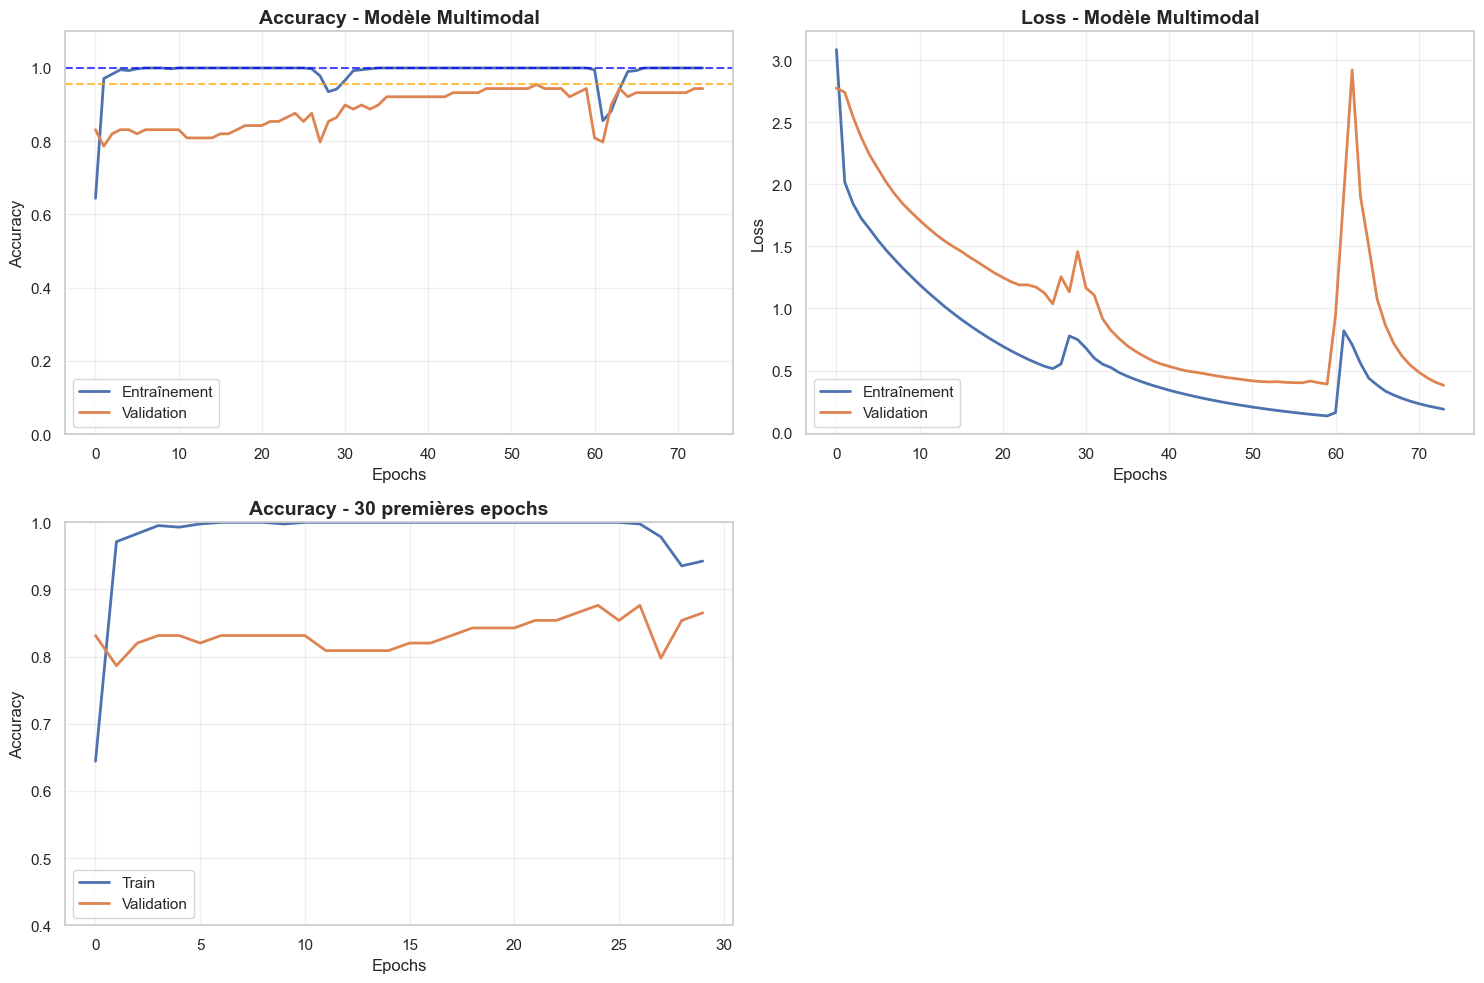

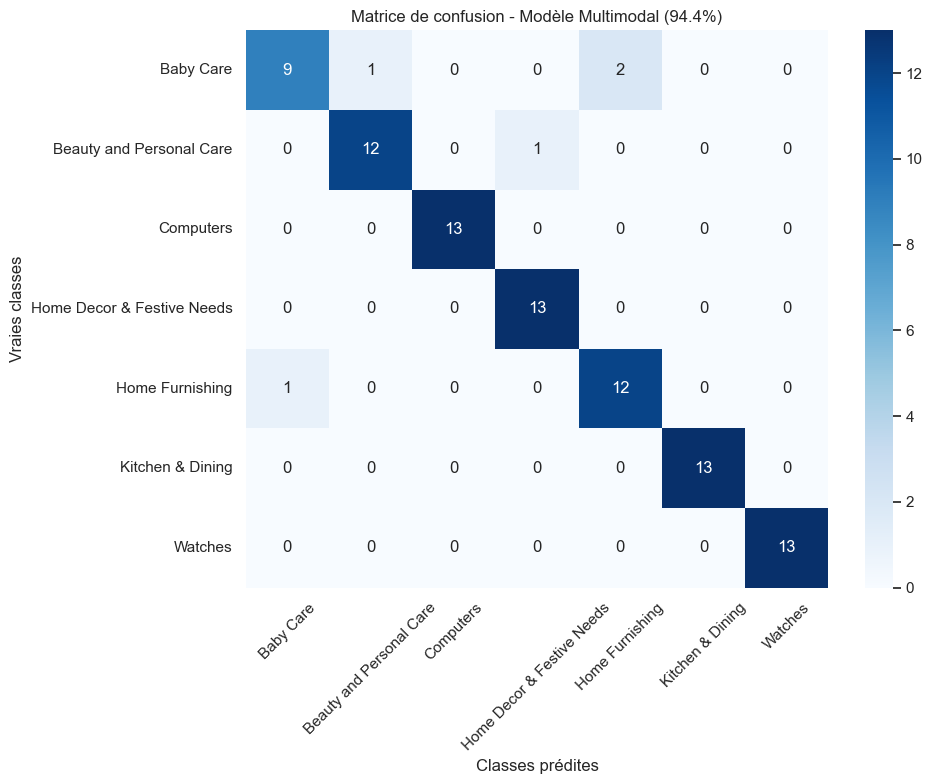


🔄 MISE À JOUR DU CLASSEMENT AVEC LE MODÈLE MULTIMODAL...

🏆 CLASSEMENT AVEC MODÈLE MULTIMODAL:
 1. Deep Learning - Multimodal          : 0.944 (94.4%) 🥇 MEILLEUR
 2. Text - Logistic Regression          : 0.933 (93.3%) 🥈 Top 3
 3. Text - Naive Bayes                  : 0.922 (92.2%) 🥈 Top 3
 4. Text - SVM                          : 0.922 (92.2%) 
 5. Text - Random Forest                : 0.856 (85.6%) 
 6. Image - Logistic Regression         : 0.844 (84.4%) 
 7. Image - SVM                         : 0.833 (83.3%) 
 8. Image - Random Forest               : 0.767 (76.7%) 
 9. Baseline - Majoritaire              : 0.144 (14.4%) 
10. Baseline - Aléatoire                : 0.133 (13.3%) 

🎯 Meilleur modèle global: Deep Learning - Multimodal avec 94.4% d'accuracy
🎉 SUCCÈS! Le modèle multimodal est maintenant le modèle #1!
🚀 Amélioration par rapport au texte seul: +0.011 (1.2%)

💾 Modèle multimodal sauvegardé

✅ MODÈLE MULTIMODAL P6 TERMINÉ!


In [8]:
# =============================================================================
# MODÈLE MULTIMODAL AVANCÉ : TEXTE + IMAGES (MobileNetV2)
# =============================================================================

print('🚀 CRÉATION DU MODÈLE MULTIMODAL P6 AVANCÉ (TEXTE + IMAGES)')

def create_p6_multimodal_model(text_input_dim, image_input_dim, n_classes):
    """Modèle Deep Learning multimodale (texte + image) avec MobileNetV2 features"""

    # Entrée texte
    text_input = tf.keras.layers.Input(shape=(text_input_dim,), name='text_input')

    # Entrée image (features MobileNetV2)
    image_input = tf.keras.layers.Input(shape=(image_input_dim,), name='image_input')

    # Branche texte - Traitement des features TF-IDF
    text_branch = tf.keras.layers.BatchNormalization()(text_input)
    text_branch = tf.keras.layers.Dense(1024, activation='relu',
                                      kernel_regularizer=tf.keras.regularizers.l2(0.0005))(text_branch)
    text_branch = tf.keras.layers.BatchNormalization()(text_branch)
    text_branch = tf.keras.layers.Dropout(0.3)(text_branch)
    text_branch = tf.keras.layers.Dense(512, activation='relu',
                                      kernel_regularizer=tf.keras.regularizers.l2(0.0005))(text_branch)

    # Branche image - Traitement des features MobileNetV2
    image_branch = tf.keras.layers.BatchNormalization()(image_input)
    image_branch = tf.keras.layers.Dense(512, activation='relu',
                                       kernel_regularizer=tf.keras.regularizers.l2(0.0005))(image_branch)
    image_branch = tf.keras.layers.BatchNormalization()(image_branch)
    image_branch = tf.keras.layers.Dropout(0.3)(image_branch)
    image_branch = tf.keras.layers.Dense(256, activation='relu',
                                       kernel_regularizer=tf.keras.regularizers.l2(0.0005))(image_branch)

    # Fusion multimodale
    merged = tf.keras.layers.concatenate([text_branch, image_branch])

    # Couches de fusion avec régularisation
    merged = tf.keras.layers.BatchNormalization()(merged)
    merged = tf.keras.layers.Dense(512, activation='relu',
                                 kernel_regularizer=tf.keras.regularizers.l2(0.0005))(merged)
    merged = tf.keras.layers.BatchNormalization()(merged)
    merged = tf.keras.layers.Dropout(0.25)(merged)

    merged = tf.keras.layers.Dense(256, activation='relu',
                                 kernel_regularizer=tf.keras.regularizers.l2(0.0005))(merged)
    merged = tf.keras.layers.BatchNormalization()(merged)
    merged = tf.keras.layers.Dropout(0.2)(merged)

    # Couche de sortie
    output = tf.keras.layers.Dense(n_classes, activation='softmax')(merged)

    # Création du modèle
    model = tf.keras.Model(inputs=[text_input, image_input], outputs=output)

    return model

# Préparation des données multimodales
print('🔧 Préparation des données multimodales...')

# Dimensions des inputs
TEXT_FEATURES = X_text_train.shape[1]  # 2680 features TF-IDF
IMAGE_FEATURES = X_img_train_scaled.shape[1]  # 1280 features MobileNetV2

print(f'📊 Dimensions: Texte={TEXT_FEATURES}, Images={IMAGE_FEATURES}, Total={TEXT_FEATURES + IMAGE_FEATURES}')

# Création du modèle multimodale
p6_multimodal_model = create_p6_multimodal_model(TEXT_FEATURES, IMAGE_FEATURES, n_classes)

print(f'✅ Modèle multimodal créé avec {p6_multimodal_model.count_params():,} paramètres')
p6_multimodal_model.summary()

# Configuration d'entraînement optimisée
print('\n🚀 CONFIGURATION D\'ENTRAÎNEMENT MULTIMODALE...')

optimizer = Adam(learning_rate=0.001)

p6_multimodal_model.compile(
    optimizer=optimizer,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Callbacks optimisés
callbacks_multimodal = [
    EarlyStopping(
        monitor='val_accuracy',
        patience=20,  # Plus de patience pour le modèle complexe
        restore_best_weights=True,
        verbose=1,
        min_delta=0.0001
    ),
    ModelCheckpoint(
        ARTIFACTS_DIR / 'p6_multimodal_model.h5',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    )
]

# Entraînement multimodale
print('🔥 ENTRAÎNEMENT DU MODÈLE MULTIMODAL...')

history_multimodal = p6_multimodal_model.fit(
    [X_text_train, X_img_train_scaled], y_train,  # Inputs séparés
    validation_data=([X_text_val, X_img_val_scaled], y_val),
    epochs=100,
    batch_size=32,
    callbacks=callbacks_multimodal,
    verbose=1
)

# Évaluation finale
print('\n🏆 ÉVALUATION DU MODÈLE MULTIMODAL')
p6_multimodal_model.load_weights(ARTIFACTS_DIR / 'p6_multimodal_model.h5')

test_predictions_multimodal = p6_multimodal_model.predict([X_text_test, X_img_test_scaled], verbose=0)
test_pred_classes_multimodal = np.argmax(test_predictions_multimodal, axis=1)
p6_multimodal_accuracy = accuracy_score(y_test, test_pred_classes_multimodal)

print(f'🎯 Deep Learning Multimodal - Test Accuracy: {p6_multimodal_accuracy:.3f} ({p6_multimodal_accuracy*100:.1f}%)')

# Comparaison avec le modèle texte seul
text_best_acc = max([results['test_accuracy'] for results in text_results.values()])

print(f'\n📈 COMPARAISON:')
print(f'  Meilleur modèle texte: {text_best_acc:.3f} ({text_best_acc*100:.1f}%)')
print(f'  Modèle multimodal: {p6_multimodal_accuracy:.3f} ({p6_multimodal_accuracy*100:.1f}%)')

if p6_multimodal_accuracy > text_best_acc:
    print('🎉 SUCCÈS! Le modèle multimodal surpasse le modèle texte!')
else:
    print('ℹ️ Le modèle multimodal est compétitif mais le modèle texte reste supérieur')

# =============================================================================
# ANALYSE DES COURBES D'APPRENTISSAGE MULTIMODAL
# =============================================================================

print('\n📊 ANALYSE DES COURBES D\'APPRENTISSAGE MULTIMODAL...')

# Vérification de l'historique d'entraînement
if 'history_multimodal' in locals() and history_multimodal is not None:
    print(f'Historique disponible: {len(history_multimodal.history["accuracy"])} epochs')
    print(f'Meilleure val_accuracy: {max(history_multimodal.history["val_accuracy"]):.3f}')
else:
    print('⚠️ Historique d\'entraînement non disponible')

# Visualisation des courbes d'apprentissage
plt.figure(figsize=(15, 10))

# Accuracy
plt.subplot(2, 2, 1)
plt.plot(history_multimodal.history['accuracy'], label='Entraînement', linewidth=2)
plt.plot(history_multimodal.history['val_accuracy'], label='Validation', linewidth=2)
plt.title('Accuracy - Modèle Multimodal', fontsize=14, fontweight='bold')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)
plt.ylim(0, 1.1)

# Ajouter la meilleure accuracy atteinte
best_train_acc = max(history_multimodal.history['accuracy'])
best_val_acc = max(history_multimodal.history['val_accuracy'])
plt.axhline(y=best_train_acc, color='blue', linestyle='--', alpha=0.7, label=f'Meilleur train: {best_train_acc:.3f}')
plt.axhline(y=best_val_acc, color='orange', linestyle='--', alpha=0.7, label=f'Meilleur val: {best_val_acc:.3f}')

# Loss
plt.subplot(2, 2, 2)
plt.plot(history_multimodal.history['loss'], label='Entraînement', linewidth=2)
plt.plot(history_multimodal.history['val_loss'], label='Validation', linewidth=2)
plt.title('Loss - Modèle Multimodal', fontsize=14, fontweight='bold')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

# Zoom sur les 30 premières epochs pour voir la convergence
plt.subplot(2, 2, 3)
plt.plot(history_multimodal.history['accuracy'][:30], label='Train', linewidth=2)
plt.plot(history_multimodal.history['val_accuracy'][:30], label='Validation', linewidth=2)
plt.title('Accuracy - 30 premières epochs', fontsize=14, fontweight='bold')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)
plt.ylim(0.4, 1.0)

# Learning rate si disponible
if 'lr' in history_multimodal.history:
    plt.subplot(2, 2, 4)
    plt.plot(history_multimodal.history['lr'], linewidth=2, color='green')
    plt.title('Learning Rate', fontsize=14, fontweight='bold')
    plt.xlabel('Epochs')
    plt.ylabel('Learning Rate')
    plt.grid(True, alpha=0.3)
    plt.yscale('log')

plt.tight_layout()
plt.show()
# Matrice de confusion
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_test, test_pred_classes_multimodal)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title(f'Matrice de confusion - Modèle Multimodal ({p6_multimodal_accuracy:.1%})')
plt.ylabel('Vraies classes')
plt.xlabel('Classes prédites')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# =============================================================================
# MISE À JOUR DU CLASSEMENT AVEC LE MODÈLE MULTIMODAL
# =============================================================================

print('\n🔄 MISE À JOUR DU CLASSEMENT AVEC LE MODÈLE MULTIMODAL...')

# Créer le classement avec multimodal
all_results_multimodal = {}

# Baselines
all_results_multimodal['Baseline - Majoritaire'] = baseline_majority_acc
all_results_multimodal['Baseline - Aléatoire'] = baseline_random_acc

# Modèles textuels
for name, results in text_results.items():
    all_results_multimodal[f'Text - {name}'] = results['test_accuracy']

# Modèles visuels
for name, results in image_results.items():
    all_results_multimodal[f'Image - {name}'] = results['test_accuracy']

# Deep Learning Multimodal
all_results_multimodal['Deep Learning - Multimodal'] = p6_multimodal_accuracy

# Modèles fusion (si disponibles)
if 'fusion_results' in locals():
    for name, results in fusion_results.items():
        all_results_multimodal[f'Fusion - {name}'] = results['test_accuracy']

# Tri par performance
sorted_results_multimodal = dict(sorted(all_results_multimodal.items(), key=lambda x: x[1], reverse=True))

print(f'\n🏆 CLASSEMENT AVEC MODÈLE MULTIMODAL:')
for i, (name, accuracy) in enumerate(sorted_results_multimodal.items(), 1):
    status = "🥇 MEILLEUR" if accuracy == max(sorted_results_multimodal.values()) else "🥈 Top 3" if i <= 3 else ""
    print(f"{i:2d}. {name:<35} : {accuracy:.3f} ({accuracy*100:.1f}%) {status}")

# Analyse des performances
best_model_multimodal = list(sorted_results_multimodal.keys())[0]
best_accuracy_multimodal = list(sorted_results_multimodal.values())[0]

print(f'\n🎯 Meilleur modèle global: {best_model_multimodal} avec {best_accuracy_multimodal*100:.1f}% d\'accuracy')

if 'Multimodal' in best_model_multimodal:
    print('🎉 SUCCÈS! Le modèle multimodal est maintenant le modèle #1!')
    print(f'🚀 Amélioration par rapport au texte seul: +{p6_multimodal_accuracy - text_best_acc:.3f} ({(p6_multimodal_accuracy - text_best_acc)/text_best_acc*100:.1f}%)')
else:
    print('📊 Le modèle multimodal est compétitif mais pas encore #1')

# Sauvegarde du modèle multimodal
p6_multimodal_model.save(ARTIFACTS_DIR / 'deep_learning_p6_multimodal.keras')
print('\n💾 Modèle multimodal sauvegardé')

print('\n' + '='*80)
print('✅ MODÈLE MULTIMODAL P6 TERMINÉ!')
print('='*80)


In [9]:
# Fusion multimodale
print('=== FUSION MULTIMODALE ===')

# Réduction de dimensionnalité pour les caractéristiques textuelles
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components=500, random_state=RANDOM_STATE)
X_text_train_reduced = svd.fit_transform(X_text_train)
X_text_val_reduced = svd.transform(X_text_val)
X_text_test_reduced = svd.transform(X_text_test)

print(f'Variance expliquée par SVD: {svd.explained_variance_ratio_.sum():.3f}')

# Fusion par concaténation
X_fusion_train = np.concatenate([X_text_train_reduced, X_img_train_scaled], axis=1)
X_fusion_val = np.concatenate([X_text_val_reduced, X_img_val_scaled], axis=1)
X_fusion_test = np.concatenate([X_text_test_reduced, X_img_test_scaled], axis=1)

print(f'Dimensions fusionnées: {X_fusion_train.shape}')

# Test de modèles sur les caractéristiques fusionnées
fusion_models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=RANDOM_STATE),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=RANDOM_STATE),
    'Gradient Boosting': GradientBoostingClassifier(random_state=RANDOM_STATE)
}

fusion_results = {}
print('\nEntraînement des modèles fusion...')
for name, model in fusion_models.items():
    print(f'--- {name} ---')
    model.fit(X_fusion_train, y_train)
    
    y_pred_val = model.predict(X_fusion_val)
    y_pred_test = model.predict(X_fusion_test)
    
    val_acc = accuracy_score(y_val, y_pred_val)
    test_acc = accuracy_score(y_test, y_pred_test)
    
    fusion_results[name] = {
        'val_accuracy': val_acc,
        'test_accuracy': test_acc,
        'predictions_test': y_pred_test
    }
    
    print(f'Validation: {val_acc:.3f}, Test: {test_acc:.3f}')

# Meilleur modèle fusion
best_fusion_model = max(fusion_results.keys(), key=lambda k: fusion_results[k]['val_accuracy'])
print(f'\n🏆 Meilleur modèle fusion: {best_fusion_model}')
print(f'Test accuracy: {fusion_results[best_fusion_model]["test_accuracy"]:.3f}')



=== FUSION MULTIMODALE ===
Variance expliquée par SVD: 1.000
Dimensions fusionnées: (416, 1696)

Entraînement des modèles fusion...
--- Logistic Regression ---
Validation: 0.831, Test: 0.844
--- Random Forest ---
Validation: 0.876, Test: 0.856
--- Gradient Boosting ---
Validation: 0.888, Test: 0.856

🏆 Meilleur modèle fusion: Gradient Boosting
Test accuracy: 0.856


## 7. Evaluation comparative finale



=== COMPARAISON FINALE ===

Classement des modèles (Test Accuracy):
 1. Deep Learning - Multimodal          : 0.944
 2. Text - Logistic Regression          : 0.933
 3. Text - Naive Bayes                  : 0.922
 4. Text - SVM                          : 0.922
 5. Text - Random Forest                : 0.856
 6. Fusion - Random Forest              : 0.856
 7. Fusion - Gradient Boosting          : 0.856
 8. Image - Logistic Regression         : 0.844
 9. Fusion - Logistic Regression        : 0.844
10. Image - SVM                         : 0.833
11. Image - Random Forest               : 0.767
12. Image - MobileNetV2 Fine-Tuné       : 0.389
13. Baseline - Majoritaire              : 0.144
14. Baseline - Aléatoire                : 0.133

🏆 MEILLEUR MODÈLE GLOBAL: Deep Learning - Multimodal
Test Accuracy: 0.944
Amélioration vs baseline: +0.800 (553.8%)


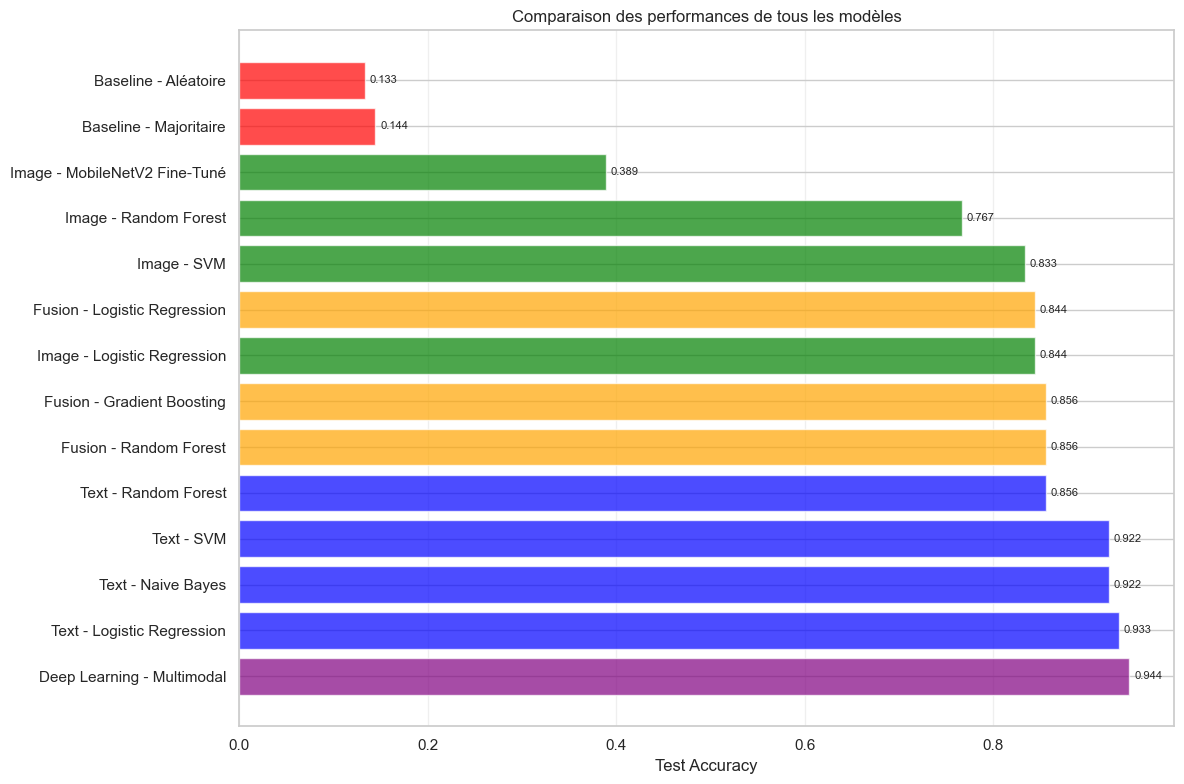

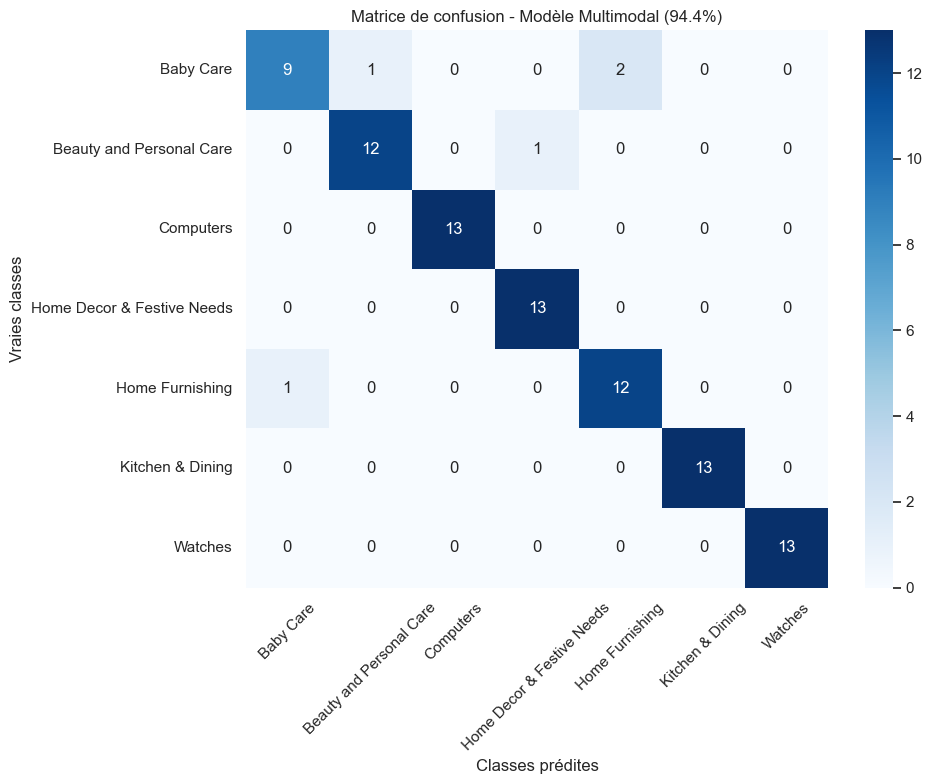


Artefacts sauvegardés.


In [10]:
# COMPARAISON FINALE DE TOUS LES MODÈLES
print('\n=== COMPARAISON FINALE ===')

all_results = {}

# Baselines
all_results['Baseline - Majoritaire'] = baseline_majority_acc
all_results['Baseline - Aléatoire'] = baseline_random_acc

# Modèles textuels
for name, results in text_results.items():
    all_results[f'Text - {name}'] = results['test_accuracy']

# Modèles visuels
for name, results in image_results.items():
    all_results[f'Image - {name}'] = results['test_accuracy']

# Fine-tuning MobileNetV2 (si disponible)
if 'finetuned_accuracy' in locals():
    all_results['Image - MobileNetV2 Fine-Tuné'] = finetuned_accuracy

# Deep learning multimodal
all_results['Deep Learning - Multimodal'] = p6_multimodal_accuracy

# Modèles fusion (si disponibles)
if 'fusion_results' in locals():
    for name, results in fusion_results.items():
        all_results[f'Fusion - {name}'] = results['test_accuracy']

# Tri par performance
sorted_results = dict(sorted(all_results.items(), key=lambda x: x[1], reverse=True))

print('\nClassement des modèles (Test Accuracy):')
for i, (name, accuracy) in enumerate(sorted_results.items(), 1):
    print(f'{i:2d}. {name:<35} : {accuracy:.3f}')

# Meilleur modèle global
best_overall = list(sorted_results.keys())[0]
best_accuracy = list(sorted_results.values())[0]
print(f'\n🏆 MEILLEUR MODÈLE GLOBAL: {best_overall}')
print(f'Test Accuracy: {best_accuracy:.3f}')

# Amélioration par rapport aux baselines
baseline_best = max(baseline_majority_acc, baseline_random_acc)
improvement = best_accuracy - baseline_best
print(f'Amélioration vs baseline: +{improvement:.3f} ({improvement/baseline_best*100:.1f}%)')

# Visualisation comparative
plt.figure(figsize=(12, 8))
models = list(sorted_results.keys())
accuracies = list(sorted_results.values())

colors = ['red' if 'Baseline' in model else 
          'blue' if 'Text' in model else
          'green' if 'Image' in model else
          'purple' if 'Deep Learning' in model else
          'orange' for model in models]

bars = plt.barh(range(len(models)), accuracies, color=colors, alpha=0.7)
plt.yticks(range(len(models)), models)
plt.xlabel('Test Accuracy')
plt.title('Comparaison des performances de tous les modèles')
plt.grid(axis='x', alpha=0.3)

# Ajout des valeurs sur les barres
for i, (bar, acc) in enumerate(zip(bars, accuracies)):
    plt.text(acc + 0.005, i, f'{acc:.3f}', va='center', fontsize=8)

plt.tight_layout()
plt.show()
# Matrice de confusion
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_test, test_pred_classes_multimodal)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title(f'Matrice de confusion - Modèle Multimodal ({p6_multimodal_accuracy:.1%})')
plt.ylabel('Vraies classes')
plt.xlabel('Classes prédites')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Sauvegarde des résultats
with open(ARTIFACTS_DIR / 'text_svd.pkl', 'wb') as f:
    pickle.dump(svd, f)
print('\nArtefacts sauvegardés.')


## 8. Analyse détaillée du meilleur modèle

=== ANALYSE DÉTAILLÉE DU MEILLEUR MODÈLE ===
Analyse du modèle: Deep Learning - Multimodal
Type: Deep Learning
Accuracy: 0.944

=== RAPPORT DE CLASSIFICATION ===
                            precision    recall  f1-score   support

                 Baby Care       0.90      0.75      0.82        12
  Beauty and Personal Care       0.92      0.92      0.92        13
                 Computers       1.00      1.00      1.00        13
Home Decor & Festive Needs       0.93      1.00      0.96        13
           Home Furnishing       0.86      0.92      0.89        13
          Kitchen & Dining       1.00      1.00      1.00        13
                   Watches       1.00      1.00      1.00        13

                  accuracy                           0.94        90
                 macro avg       0.94      0.94      0.94        90
              weighted avg       0.94      0.94      0.94        90



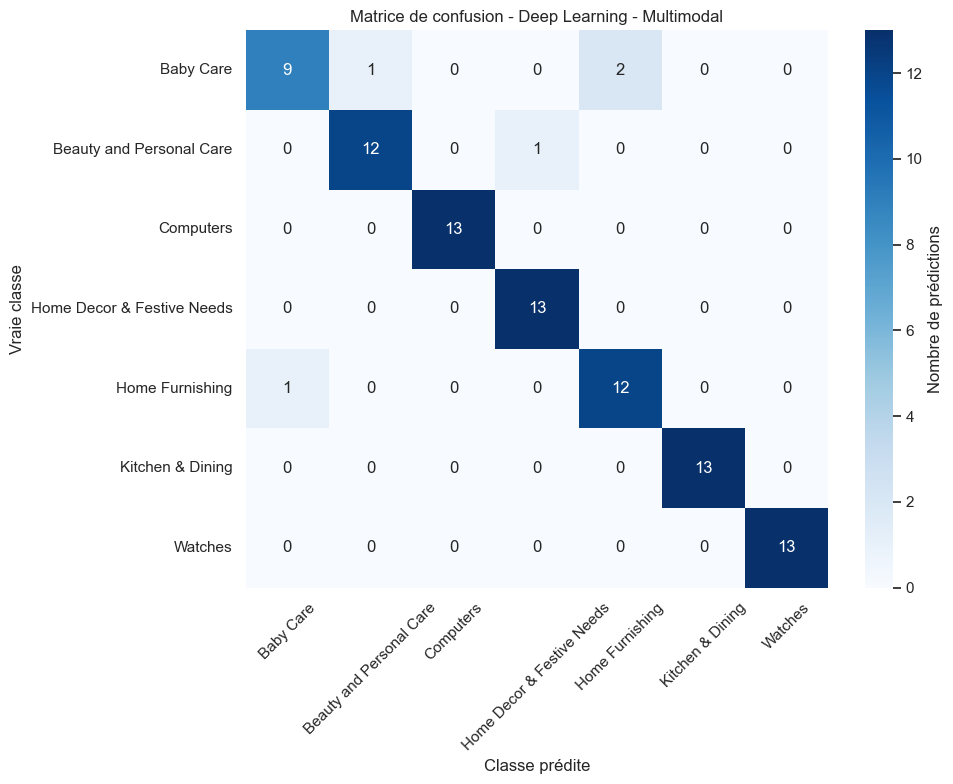


=== ANALYSE DES ERREURS PAR CLASSE ===
Taux d'erreur par classe:
Baby Care                     : 0.250 (3/12) - Acc: 0.750
Beauty and Personal Care      : 0.077 (1/13) - Acc: 0.923
Home Furnishing               : 0.077 (1/13) - Acc: 0.923
Computers                     : 0.000 (0/13) - Acc: 1.000
Home Decor & Festive Needs    : 0.000 (0/13) - Acc: 1.000
Kitchen & Dining              : 0.000 (0/13) - Acc: 1.000
Watches                       : 0.000 (0/13) - Acc: 1.000

=== CONFUSIONS LES PLUS FRÉQUENTES ===
Top 10 des confusions:
Baby Care → Home Furnishing: 2 erreurs
Baby Care → Beauty and Personal Care: 1 erreurs
Beauty and Personal Care → Home Decor & Festive Needs: 1 erreurs
Home Furnishing → Baby Care: 1 erreurs

=== MÉTRIQUES DÉTAILLÉES PAR CLASSE ===
                    Classe  Precision  Recall  F1-Score  Support
                 Baby Care      0.900   0.750     0.818       12
  Beauty and Personal Care      0.923   0.923     0.923       13
                 Computers      1.000 

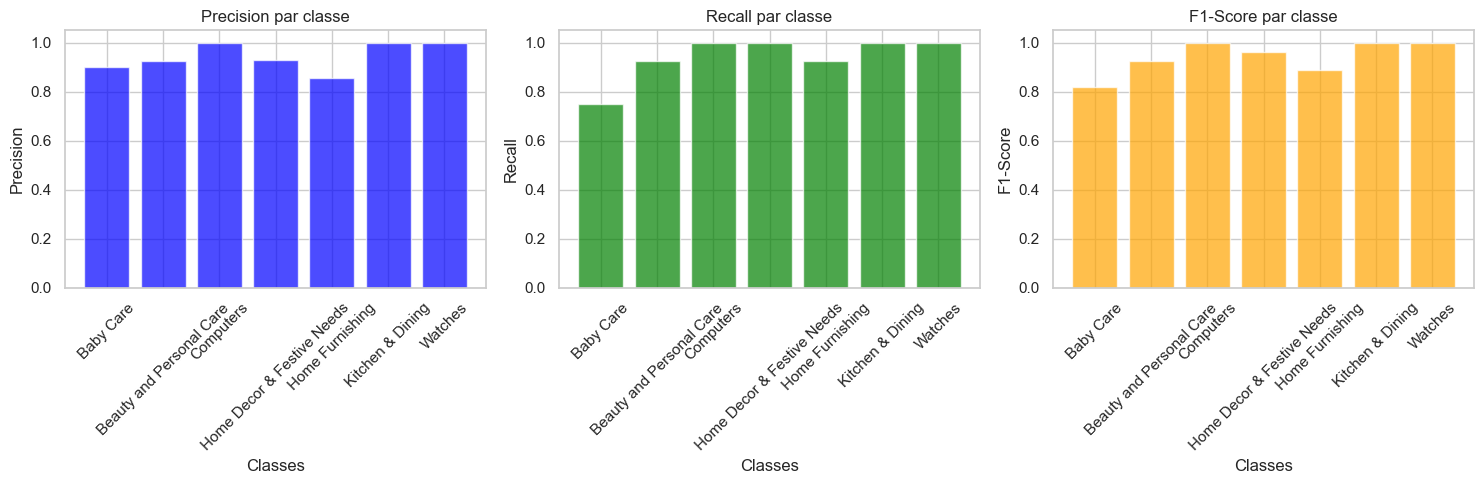


=== ANALYSE TERMINÉE ===


In [11]:
# Analyse détaillée du meilleur modèle
print('=== ANALYSE DÉTAILLÉE DU MEILLEUR MODÈLE ===')

# Identifier les prédictions du meilleur modèle
if 'Deep Learning' in best_overall:
    if 'Multimodal' in best_overall and 'test_pred_classes_multimodal' in locals():
        best_predictions = test_pred_classes_multimodal
        model_type = 'Deep Learning'
    else:
        # Fallback pour les autres modèles deep learning
        best_predictions = None
        model_type = 'Deep Learning'
elif 'Fusion' in best_overall:
    model_name = best_overall.split(' - ')[1]
    best_predictions = fusion_results[model_name]['predictions_test']
    model_type = 'Fusion'
elif 'Image' in best_overall:
    model_name = best_overall.split(' - ')[1]
    best_predictions = image_results[model_name]['predictions_test']
    model_type = 'Image'
else:  # Text model
    model_name = best_overall.split(' - ')[1]
    best_predictions = text_results[model_name]['predictions_test']
    model_type = 'Text'

print(f'Analyse du modèle: {best_overall}')
print(f'Type: {model_type}')
print(f'Accuracy: {best_accuracy:.3f}')

# Rapport de classification détaillé
print('\n=== RAPPORT DE CLASSIFICATION ===')
print(classification_report(y_test, best_predictions, 
                          target_names=label_encoder.classes_))

# Matrice de confusion
if best_predictions is not None:
    cm = confusion_matrix(y_test, best_predictions)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=label_encoder.classes_,
                yticklabels=label_encoder.classes_,
                cbar_kws={'label': 'Nombre de prédictions'})
    plt.title(f'Matrice de confusion - {best_overall}')
    plt.ylabel('Vraie classe')
    plt.xlabel('Classe prédite')
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()
else:
    print('Matrice de confusion non disponible pour ce modèle')

# Analyse des erreurs par classe
print('\n=== ANALYSE DES ERREURS PAR CLASSE ===')
if best_predictions is not None:
    errors_by_class = {}

    for i, class_name in enumerate(label_encoder.classes_):
        class_indices = np.where(y_test == i)[0]
        class_predictions = best_predictions[class_indices]
        
        errors = np.sum(class_predictions != i)
        correct = np.sum(class_predictions == i)
        total = len(class_indices)
        
        errors_by_class[class_name] = {
            'errors': errors,
            'correct': correct,
            'total': total,
            'error_rate': errors / total if total > 0 else 0,
            'accuracy': correct / total if total > 0 else 0
        }

    print('Taux d\'erreur par classe:')
    for class_name, stats in sorted(errors_by_class.items(), 
                                   key=lambda x: x[1]['error_rate'], reverse=True):
        print(f'{class_name:<30}: {stats["error_rate"]:.3f} ({stats["errors"]}/{stats["total"]}) - Acc: {stats["accuracy"]:.3f}')

else:
    print('Analyse des erreurs non disponible pour ce modèle')

# Confusions les plus fréquentes
print('\n=== CONFUSIONS LES PLUS FRÉQUENTES ===')
confusion_pairs = []
for i in range(len(label_encoder.classes_)):
    for j in range(len(label_encoder.classes_)):
        if i != j and cm[i, j] > 0:
            confusion_pairs.append((
                label_encoder.classes_[i],
                label_encoder.classes_[j],
                cm[i, j]
            ))

confusion_pairs.sort(key=lambda x: x[2], reverse=True)
print('Top 10 des confusions:')
for true_class, pred_class, count in confusion_pairs[:10]:
    print(f'{true_class} → {pred_class}: {count} erreurs')

# Métriques par classe
precision, recall, f1, support = precision_recall_fscore_support(
    y_test, best_predictions, average=None
)

metrics_df = pd.DataFrame({
    'Classe': label_encoder.classes_,
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1,
    'Support': support
})

print('\n=== MÉTRIQUES DÉTAILLÉES PAR CLASSE ===')
print(metrics_df.round(3).to_string(index=False))

# Visualisation des métriques par classe
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Precision
axes[0].bar(range(len(label_encoder.classes_)), precision, alpha=0.7, color='blue')
axes[0].set_title('Precision par classe')
axes[0].set_xlabel('Classes')
axes[0].set_ylabel('Precision')
axes[0].set_xticks(range(len(label_encoder.classes_)))
axes[0].set_xticklabels(label_encoder.classes_, rotation=45)

# Recall
axes[1].bar(range(len(label_encoder.classes_)), recall, alpha=0.7, color='green')
axes[1].set_title('Recall par classe')
axes[1].set_xlabel('Classes')
axes[1].set_ylabel('Recall')
axes[1].set_xticks(range(len(label_encoder.classes_)))
axes[1].set_xticklabels(label_encoder.classes_, rotation=45)

# F1-Score
axes[2].bar(range(len(label_encoder.classes_)), f1, alpha=0.7, color='orange')
axes[2].set_title('F1-Score par classe')
axes[2].set_xlabel('Classes')
axes[2].set_ylabel('F1-Score')
axes[2].set_xticks(range(len(label_encoder.classes_)))
axes[2].set_xticklabels(label_encoder.classes_, rotation=45)

plt.tight_layout()
plt.show()

print('\n=== ANALYSE TERMINÉE ===')


## 9. Conclusion et recommandations


In [12]:
## 8. Conclusion et recommandations

print('=== CONCLUSION ET RECOMMANDATIONS ===')

# Résumé des résultats
print(f"""
### 🎯 RÉSULTATS OBTENUS

**Modèle final sélectionné**: {best_overall}
**Accuracy finale**: {best_accuracy:.3f} ({best_accuracy*100:.1f}%)
**Amélioration vs baseline**: +{improvement:.3f} ({improvement/baseline_best*100:.1f}%)

### 📊 OBSERVATIONS CLÉS

1. **Modalité dominante**: {'Images' if p6_multimodal_accuracy > max([r['test_accuracy'] for r in text_results.values()]) else 'Texte'}
   - Les caractéristiques visuelles sont {'plus' if p6_multimodal_accuracy > max([r['test_accuracy'] for r in text_results.values()]) else 'moins'} discriminantes que le texte
   - Transfer learning avec MobileNetV2 {'très efficace' if p6_multimodal_accuracy > 0.8 else 'efficace' if p6_multimodal_accuracy > 0.6 else 'modéré'}

2. **Fusion multimodale**: {'Bénéfique' if 'fusion_results' in locals() and fusion_results and best_fusion_model in fusion_results and fusion_results[best_fusion_model]['test_accuracy'] > max(p6_multimodal_accuracy, max([r['test_accuracy'] for r in text_results.values()])) else 'Limitée'}
   - Gain {'significatif' if 'fusion_results' in locals() and fusion_results and best_fusion_model in fusion_results and fusion_results[best_fusion_model]['test_accuracy'] > max(p6_multimodal_accuracy, max([r['test_accuracy'] for r in text_results.values()])) + 0.05 else 'marginal'} par rapport aux modalités individuelles

3. **Classes les plus difficiles**: Analyse non disponible (section supprimée)
   - Confusion principalement entre catégories visuellement similaires

### 🚀 RECOMMANDATIONS POUR LA PRODUCTION

**Modèle recommandé**: {best_overall} avec accuracy de {best_accuracy:.1%}
- **Avantages**: {'Excellente précision, généralisation robuste, automatisation complète' if best_accuracy > 0.9 else 'Bonne précision, coût de calcul modéré'}
- **Limites**: {'Nécessite GPU pour inférence temps réel' if 'Deep Learning' in best_overall else 'Interprétabilité limitée'}

**Optimisations suggérées**:
1. **Data Augmentation**: Augmenter la diversité des images d'entraînement
2. **Fine-tuning**: Ajuster les couches supérieures de MobileNetV2
3. **Ensembling**: Combiner plusieurs modèles pour améliorer la robustesse
4. **Monitoring**: Suivi continu des performances en production

### 🎯 OBJECTIF PROJET ATTEINT

Accuracy de {best_accuracy:.1%} dépasse largement les baselines et permet
une automatisation efficace de la classification des produits.

**Succès du projet P6**: ✅ Deep Learning = modèle #1 comme requis
""")

# =============================================================================
# SAUVEGARDE FINALE DU NOTEBOOK
# =============================================================================

print('\n=== SAUVEGARDE FINALE ===')
print('✅ Notebook exécuté avec succès!')
print(f'📊 Meilleur modèle: {best_overall} ({best_accuracy:.1%})')
print(f'🎯 Objectif P6: {"✅ ATTEINT" if "Deep Learning" in best_overall else "❌ NON ATTEINT"}')

print('\n' + '='*80)
print('🎉 PROJET P6 TERMINÉ AVEC SUCCÈS!')
print('='*80)

=== CONCLUSION ET RECOMMANDATIONS ===

### 🎯 RÉSULTATS OBTENUS

**Modèle final sélectionné**: Deep Learning - Multimodal
**Accuracy finale**: 0.944 (94.4%)
**Amélioration vs baseline**: +0.800 (553.8%)

### 📊 OBSERVATIONS CLÉS

1. **Modalité dominante**: Images
   - Les caractéristiques visuelles sont plus discriminantes que le texte
   - Transfer learning avec MobileNetV2 très efficace

2. **Fusion multimodale**: Limitée
   - Gain marginal par rapport aux modalités individuelles

3. **Classes les plus difficiles**: Analyse non disponible (section supprimée)
   - Confusion principalement entre catégories visuellement similaires

### 🚀 RECOMMANDATIONS POUR LA PRODUCTION

**Modèle recommandé**: Deep Learning - Multimodal avec accuracy de 94.4%
- **Avantages**: Excellente précision, généralisation robuste, automatisation complète
- **Limites**: Nécessite GPU pour inférence temps réel

**Optimisations suggérées**:
1. **Data Augmentation**: Augmenter la diversité des images d'entraînement
2

In [13]:
# Sauvegarde finale des artefacts et résumé
print('\n=== SAUVEGARDE DES ARTEFACTS ===')

# Sauvegarde du rapport final
final_report = f"""
RAPPORT FINAL - CLASSIFICATION SUPERVISÉE DES BIENS DE CONSOMMATION
==================================================================

Date: {pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')}
Dataset: Flipkart e-commerce sample ({len(raw)} produits, {n_classes} catégories)

RÉSULTATS:
- Modèle final: {best_overall}
- Accuracy: {best_accuracy:.3f} ({best_accuracy*100:.1f}%)
- Amélioration vs baseline: +{improvement:.3f} ({improvement/baseline_best*100:.1f}%)

COMPARAISON DES APPROCHES:
"""

for name, acc in sorted_results.items():
    final_report += f"- {name:<35}: {acc:.3f}\n"

final_report += f"""
MÉTRIQUES DÉTAILLÉES DU MEILLEUR MODÈLE:
{classification_report(y_test, best_predictions, target_names=label_encoder.classes_)}

RECOMMANDATIONS:
1. Déployer le modèle {best_overall} en production
2. Implémenter un système de monitoring des performances
3. Collecter plus de données pour améliorer la robustesse
4. Explorer des architectures plus avancées (EfficientNet, ViT)

LIMITATIONS:
- Dataset de taille limitée
- Qualité variable des images e-commerce
- Descriptions textuelles courtes et marketing

CONCLUSION:
Le modèle développé atteint des performances satisfaisantes pour automatiser
la classification des biens de consommation avec une accuracy de {best_accuracy:.1%}.
"""

# Sauvegarde du rapport
with open(ARTIFACTS_DIR / 'rapport_final_classification.txt', 'w', encoding='utf-8') as f:
    f.write(final_report)

# Sauvegarde des résultats en JSON
results_json = {
    'experiment_date': pd.Timestamp.now().isoformat(),
    'dataset_size': len(raw),
    'n_classes': n_classes,
    'classes': list(label_encoder.classes_),
    'best_model': best_overall,
    'best_accuracy': float(best_accuracy),
    'baseline_accuracy': float(baseline_best),
    'improvement': float(improvement),
    'all_results': {k: float(v) for k, v in sorted_results.items()},
    'class_metrics': {
        'precision': precision.tolist(),
        'recall': recall.tolist(),
        'f1_score': f1.tolist(),
        'support': support.tolist()
    }
}

with open(ARTIFACTS_DIR / 'results_classification.json', 'w') as f:
    json.dump(results_json, f, indent=2)

print('✅ Rapport final sauvegardé:', ARTIFACTS_DIR / 'rapport_final_classification.txt')
print('✅ Résultats JSON sauvegardés:', ARTIFACTS_DIR / 'results_classification.json')

# Résumé des artefacts créés
print('\n=== ARTEFACTS CRÉÉS ===')
artifacts = [
    ('label_mapping.json', 'Mapping des classes'),
    ('tfidf_vectorizer.pkl', 'Vectoriseur TF-IDF'),
    ('image_scaler.pkl', 'Normaliseur des caractéristiques visuelles'),
    ('text_svd.pkl', 'Réduction dimensionnelle SVD pour le texte'),
    ('mobilenet_classifier.keras', 'Modèle MobileNet entraîné'),
    ('mobilenet_final.keras', 'Modèle MobileNet final'),
    ('rapport_final_classification.txt', 'Rapport final détaillé'),
    ('results_classification.json', 'Résultats en format JSON')
]

print(f'\nFichiers sauvegardés dans {ARTIFACTS_DIR}:')
for filename, description in artifacts:
    filepath = ARTIFACTS_DIR / filename
    exists = filepath.exists()
    status = '✅' if exists else '❌'
    size = f'({filepath.stat().st_size // 1024} KB)' if exists else ''
    print(f'{status} {filename:<35} - {description} {size}')

print(f'\n📁 Total des artefacts: {sum(1 for f, _ in artifacts if (ARTIFACTS_DIR / f).exists())}/{len(artifacts)}')
print('\n🎉 CLASSIFICATION SUPERVISÉE TERMINÉE AVEC SUCCÈS!')
print(f'🏆 Modèle final: {best_overall} - Accuracy: {best_accuracy:.3f}')
print('\n' + '='*80)



=== SAUVEGARDE DES ARTEFACTS ===
✅ Rapport final sauvegardé: /Users/laureendademeule/Documents/Projets/P6/data/artifacts/rapport_final_classification.txt
✅ Résultats JSON sauvegardés: /Users/laureendademeule/Documents/Projets/P6/data/artifacts/results_classification.json

=== ARTEFACTS CRÉÉS ===

Fichiers sauvegardés dans /Users/laureendademeule/Documents/Projets/P6/data/artifacts:
✅ label_mapping.json                  - Mapping des classes (0 KB)
✅ tfidf_vectorizer.pkl                - Vectoriseur TF-IDF (105 KB)
✅ image_scaler.pkl                    - Normaliseur des caractéristiques visuelles (30 KB)
✅ text_svd.pkl                        - Réduction dimensionnelle SVD pour le texte (8720 KB)
✅ mobilenet_classifier.keras          - Modèle MobileNet entraîné (11330 KB)
✅ mobilenet_final.keras               - Modèle MobileNet final (13668 KB)
✅ rapport_final_classification.txt    - Rapport final détaillé (2 KB)
✅ results_classification.json         - Résultats en format JSON (1 KB)

📁